In [ ]:
mixer.run1 - constrain QQ plots to HM3
mixer.run2 - use all SNPs but did not adjust sig2_zeroA
mixer.run3 - use all SNPs and adjust sig2_zeroA to the full template
mixer.run4 - fit and test

In [1]:
import json
data1 = json.loads(open('/home/oleksanf/github/mixer/precimed/mixer.run1.json').read())
data2 = json.loads(open('/home/oleksanf/github/mixer/precimed/mixer.run2.json').read())
data3 = json.loads(open('/home/oleksanf/github/mixer/precimed/mixer.run3.json').read())
data4 = json.loads(open('/home/oleksanf/github/mixer/precimed/mixer.run4.json').read())

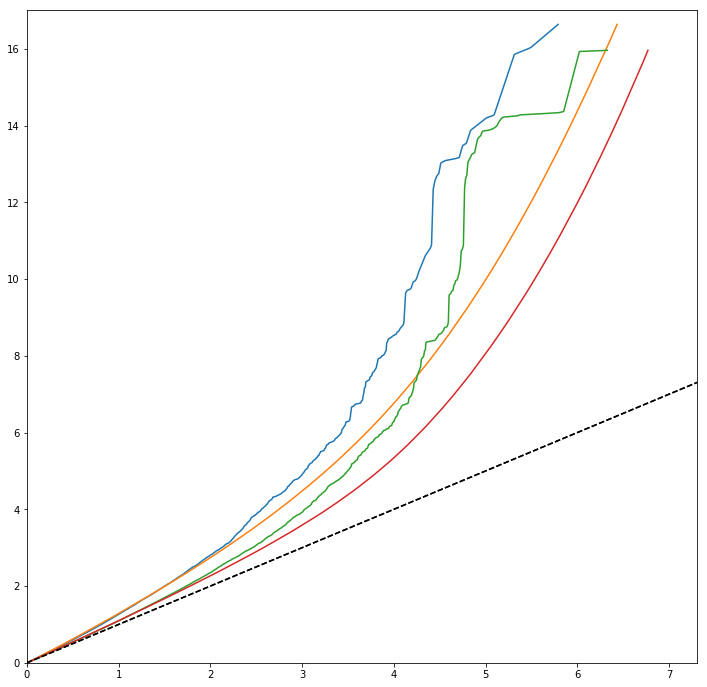

In [30]:
plt.figure(figsize=[12, 12])
precimed.mixer.figures.make_qq_plot(data4['m01']['qqplot_fit'], ylim=17, ci=False)
precimed.mixer.figures.make_qq_plot(data4['m01']['qqplot_test'], ylim=17, ci=False)


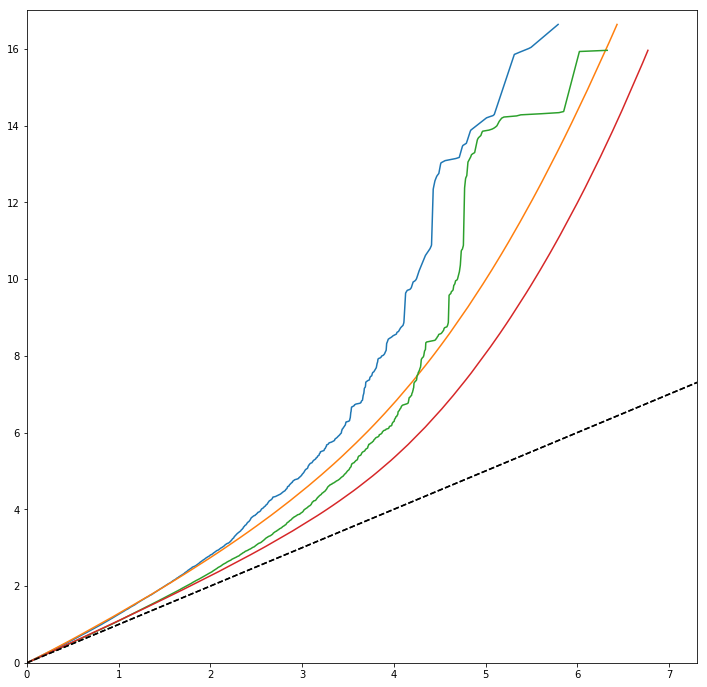

In [23]:
data1['m01']['qqplot'].keys()
plt.figure(figsize=[12, 12])
precimed.mixer.figures.make_qq_plot(data1['m01']['qqplot'], ylim=17, ci=False)
#precimed.mixer.figures.make_qq_plot(data2['m01']['qqplot'], ylim=7, ci=False)
precimed.mixer.figures.make_qq_plot(data3['m01']['qqplot'], ylim=17, ci=False)


In [1]:
folder = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/LDSR/LDSR_Annot/1000G_EUR_Phase3_baseline/'
#df_ldsc=pd.concat([pd.read_csv(folder + 'baseline.{}.annot.gz'.format(chri),sep='\t') for chri in range(1, 23)])

fname='ldsr.baseline.sorted.complete_annot_hg19.annomat.uniq.8categories.txt.gz'
#df=pd.read_csv(fname,sep='\t')
df['base']=1
df['CHR']=df_ldsc['CHR'].values
df['BP']=df_ldsc['BP'].values
df['CM']=df_ldsc['CM'].values
first_columns = ['CHR', 'BP', 'SNP', 'CM', 'base']
for chri in range(1, 23):
    df[['CHR', 'BP', 'SNP', 'CM', 'base'] + [x for x in df.columns.values if x not in first_columns]][df['CHR']==chri].to_csv(fname.replace('.txt.gz', '.chr'+str(chri) + '.txt'), index=False, sep='\t')


NameError: name 'df' is not defined

In [14]:
import pandas as pd
import numpy as np
folder = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/LDSR/LDSR_Annot/1000G_EUR_Phase3_baseline/'
#baseline.10.annot.gz
annonames = [x.replace('.bedL2', '') for x in pd.read_csv(folder+'baseline.21.l2.ldscore.gz',sep='\t').columns[3:]]

df=pd.concat([pd.read_csv(folder + 'baseline.{}.annot.gz'.format(chri),sep='\t') for chri in [1]])
#df=pd.concat([pd.read_csv(folder + 'baseline.{}.annot.gz'.format(chri),sep='\t') for chri in range(1, 23)])

del df['CHR']
del df['BP']
del df['SNP']
del df['CM']
annomat = df.values.astype(np.float32)

In [7]:
%load_ext autoreload
%autoreload 2

figures_folder = 'png_oct6/'

import precimed
import precimed.mixer
import precimed.mixer.libbgmg
import precimed.mixer.utils
import precimed.mixer.cli
import precimed.mixer.figures
import numpy as np
import numpy.matlib
from precimed.mixer.utils import UnivariateParams
from precimed.mixer.utils import AnnotUnivariateParams
from precimed.mixer.utils import _log_exp_converter
from precimed.mixer.utils import _arctanh_tanh_converter
from precimed.mixer.utils import _logit_logistic_converter
import scipy.optimize
import matplotlib.pyplot as plt
import statsmodels.api as sm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%load_ext autoreload
%autoreload 2

figures_folder = 'png_oct6/'

import precimed
import precimed.mixer
import precimed.mixer.libbgmg
import precimed.mixer.utils
import precimed.mixer.cli
import precimed.mixer.figures
import numpy as np
import numpy.matlib
from precimed.mixer.utils import UnivariateParams
from precimed.mixer.utils import AnnotUnivariateParams
from precimed.mixer.utils import _log_exp_converter
from precimed.mixer.utils import _arctanh_tanh_converter
from precimed.mixer.utils import _logit_logistic_converter
import scipy.optimize
import matplotlib.pyplot as plt
import statsmodels.api as sm

libbgmg = precimed.mixer.libbgmg.LibBgmg('/home/oleksanf/github/mixer/src/build/lib/libbgmg.so', dispose=False)

def perform_fit(bounds_left, bounds_right, parametrization):
    libbgmg.set_option('cost_calculator', _cost_calculator_gaussian)

    bounds4opt = [(l, r) for l, r in zip(parametrization.params_to_vec(bounds_left), parametrization.params_to_vec(bounds_right))]
    optimize_result = scipy.optimize.differential_evolution(lambda x: parametrization.calc_cost(x), bounds4opt,
        tol=0.01, mutation=(0.5, 1), recombination=0.7, atol=0, updating='immediate', polish=False, workers=1)  #, **global_opt_options)
    params = parametrization.vec_to_params(optimize_result.x)
    print(params)

    # Step 2. neldermead-fast
    optimize_result = scipy.optimize.minimize(lambda x: parametrization.calc_cost(x), parametrization.params_to_vec(params),
        method='Nelder-Mead', options={'maxiter':240, 'fatol':1e-7, 'xatol':1e-4, 'adaptive':True})
    params = parametrization.vec_to_params(optimize_result.x)
    print(params)
    
    if 0:
        libbgmg.set_option('cost_calculator', _cost_calculator_sampling)
        # Step 3. neldermead (sampling)
        optimize_result = scipy.optimize.minimize(lambda x: parametrization.calc_cost(x), parametrization.params_to_vec(params),
            method='Nelder-Mead', options={'maxiter':240, 'fatol':1e-7, 'xatol':1e-4, 'adaptive':True})
        params = parametrization.vec_to_params(optimize_result.x)
        print(params)
    
    return params

if 0:
    class UnifiedUnivariateParams(object):
        def __init__(self, pi, sig2_beta, sig2_zeroA, s, l, sig2_annomat=None):
            self._pi = pi
            self._sig2_beta = sig2_beta
            self._sig2_zeroA = sig2_zeroA
            self._s = s;
            self._l = l;
            self._sig2_annomat = sig2_annomat

        def __str__(self):
            description = []
            for attr_name in '_pi', '_sig2_beta', '_sig2_zeroA', '_s', '_l':
                try:
                    attr_value = getattr(self, attr_name)
                    description.append('{}: {}'.format(attr_name, attr_value))
                except RuntimeError:
                    pass
            return 'UnifiedUnivariateParams({})'.format(', '.join(description))
        __repr__ = __str__

        def as_dict(self):
            return {'pi': self._pi, 'sig2_beta': self._sig2_beta, 'sig2_zeroA': self._sig2_zeroA, 's': self._s, 'l': self._l}

        def cost(self, lib, trait):
            pi_vec = self._pi * np.ones(shape=(lib.num_snp, 1), dtype=np.float32)
            mafvec = libbgmg.mafvec;
            tldvec = libbgmg.ld_tag_r2_sum;
            if self._sig2_annomat is not None:
                sig2_vec = np.multiply(np.dot(self._sig2_annomat, np.array(self._sig2_beta).astype(np.float32)),
                                       np.multiply(np.power(np.float32(2.0) * mafvec * (1-mafvec), np.float32(self._s)),
                                                   np.power(tldvec, np.float32(self._l))))
            else:
                sig2_vec = self._sig2_beta * np.multiply(np.power(2 * mafvec * (1-mafvec), self._s), np.power(tldvec, self._l))

            sig2_zeroL = 1 # self._sig2_beta * self._pi
            sig2_zeroC = 1
            value = lib.calc_unified_univariate_cost(trait, pi_vec, sig2_vec, self._sig2_zeroA, sig2_zeroC, sig2_zeroL)
            return value if np.isfinite(value) else 1e100

        def pdf(self, lib, trait, zgrid):
            pi_vec = self._pi * np.ones(shape=(lib.num_snp, 1), dtype=np.float32)
            mafvec = libbgmg.mafvec;
            tldvec = libbgmg.ld_tag_r2_sum;
            if self._sig2_annomat is not None:
                sig2_vec = np.multiply(np.dot(self._sig2_annomat, np.array(self._sig2_beta).astype(np.float32)),
                                       np.multiply(np.power(2 * mafvec * (1-mafvec), self._s),
                                                   np.power(tldvec, self._l)))
            else:
                sig2_vec = self._sig2_beta * np.multiply(np.power(2 * mafvec * (1-mafvec), self._s), np.power(tldvec, self._l))
            sig2_zeroL = 1 # self._sig2_beta * self._pi
            sig2_zeroC = 1
            return libbgmg.calc_unified_univariate_pdf(trait, pi_vec, sig2_vec, self._sig2_zeroA, sig2_zeroC, sig2_zeroL, zgrid)

    class UnifiedUnivariateParametrization_natural_axis(object):
        def __init__(self, lib, trait, sig2_annomat):
            self._lib = lib
            self._trait = trait
            self._sig2_annomat = sig2_annomat

        def params_to_vec(self, params):
            return [_log_exp_converter(params._sig2_zeroA, invflag=False),
                    #_logit_logistic_converter(params._pi, invflag=False),
                    #params._s,
                    #params._l,
                   ] + [_log_exp_converter(x, invflag=False) for x in params._sig2_beta]

        def vec_to_params(self, vec):
            index = 0;
            sig2_zeroA=_log_exp_converter(vec[index], invflag=True); index=index+1
            pi = 1 #_logit_logistic_converter(vec[index], invflag=True); index=index+1
            s = 0 #vec[index]; index=index+1
            l = 0 #vec[index]; index=index+1
            sig2_beta=[_log_exp_converter(x, invflag=True) for x in vec[index:]]

            return UnifiedUnivariateParams(pi=pi, sig2_beta=sig2_beta, sig2_zeroA=sig2_zeroA, s=s, l=l, sig2_annomat=self._sig2_annomat)

        def calc_cost(self, vec):
            return self.vec_to_params(vec).cost(self._lib, self._trait)

    #print(UnivariateParams(pi=0.004, sig2_beta=5.842e-5, sig2_zero=1.185).cost(libbgmg, 1))
    #print(UnifiedUnivariateParams(pi=0.004, sig2_beta=5.842e-5, sig2_zeroA=1.185, s=0.0).cost(libbgmg, 1))
    
def do_plots(params, label, ylims=[7.3, 20, 50, 150], strat=True):
    data = {}
    trait_index = 1
    downsample_factor=50
    mask = np.isfinite(libbgmg.zvec1)
    data['qqplot'] = precimed.mixer.cli.calc_qq_plot(libbgmg, params, 1, downsample_factor, mask)
    for ylim in ylims:
        precimed.mixer.figures.make_qq_plot(data['qqplot'], ylim=ylim)
        plt.savefig(figures_folder + label + 'ylim={}.qq.png'.format(ylim) , bbox_inches='tight')

    if not strat: return
    mafvec = libbgmg.mafvec[libbgmg.defvec]
    tldvec = libbgmg.ld_tag_r2_sum
    maf_bins = np.concatenate(([-np.inf], np.quantile(mafvec, [1/3, 2/3]), [np.inf]))
    tld_bins = np.concatenate(([-np.inf], np.quantile(tldvec, [1/3, 2/3]), [np.inf]))
    data['qqplot_bins'] = []
    for i in range(0, 3):
        for j in range(0, 3):
            mask = np.isfinite(libbgmg.zvec1) & ((mafvec>=maf_bins[i]) & (mafvec<maf_bins[i+1]) & (tldvec >= tld_bins[j]) &  (tldvec < tld_bins[j+1]))
            data['qqplot_bins'].append(precimed.mixer.cli.calc_qq_plot(libbgmg, params, trait_index, downsample_factor, mask,
                title='maf \\in [{:.3g},{:.3g}); L \\in [{:.3g},{:.3g})'.format(maf_bins[i], maf_bins[i+1], tld_bins[j], tld_bins[j+1])))

    for ylim in ylims:            
        plt.figure(figsize=[12, 12])
        for i in range(0, 3):
            for j in range(0, 3):
                plt.subplot(3,3,i*3+j+1)
                precimed.mixer.figures.make_qq_plot(data['qqplot_bins'][i*3+j], ylim=ylim)
                plt.title(data['qqplot_bins'][i*3+j]['title'].replace(';', '\n'))
        plt.savefig(figures_folder + label + 'ylim={}.binqq.png'.format(ylim) , bbox_inches='tight')    

In [16]:
libbgmg = precimed.mixer.libbgmg.LibBgmg('/home/oleksanf/github/mixer/src/build/lib/libbgmg.so', dispose=True)
libbgmg.init_log('/home/oleksanf/github/mixer/src/build/lib/mixer.log')

# ToDo: optimize gaussian cost function to benefit from complete tag indices. 
# In this case we don't need to compute redundant Edelta2 and Edelta4 for undefined tag indices.
libbgmg.set_option('use_complete_tag_indices', 1)

bim_file = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink/1000G.EUR.QC.@.bim'
frq_file = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink_freq/1000G.EUR.QC.@.frq'
plink_ld_bin0 = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink/1000G.EUR.QC.@.p05_SNPwind50k.ld.bin'
trait1_file = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/TMP/ldsr/SSGAC_EDU_2018_no23andMe.sumstats.gz'
#trait1_file = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/TMP/ldsr/GIANT_HEIGHT_2018_UKB.sumstats.gz'
trait2_file = ''
extract = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/LDSR/w_hm3.justrs'
exclude = ''
chr2use = [1] # range(1, 23)
_cost_calculator_sampling = 0
_cost_calculator_gaussian = 1
_cost_calculator_convolve = 2

libbgmg.init(bim_file, frq_file, chr2use, trait1_file, trait2_file, exclude, extract)
libbgmg.set_option('ld_format_version', 0)
libbgmg.set_option('seed', 123)
libbgmg.set_option('cubature_rel_error', 1e-5)
libbgmg.set_option('cubature_max_evals', 1000)
libbgmg.set_option('cost_calculator', _cost_calculator_gaussian)

for chr_label in chr2use: 
    libbgmg.set_ld_r2_coo_from_file(int(chr_label), plink_ld_bin0.replace('@', str(chr_label)))
    libbgmg.set_ld_r2_csr(int(chr_label))
libbgmg.set_weights_randprune(64, 0.1)

mafvec = libbgmg.mafvec[libbgmg.defvec]
hetvec = 2 * np.multiply(mafvec, 1-mafvec)


In [ ]:
                  [pi, sig2_beta, sig2_zeroA, s, l] 
or
        [annots], [pi, sig2_beta, sig2_zeroA, s, l] 
or
[s, l], [annots], [pi, sig2_beta, sig2_zeroA, s, l] 

In [ ]:
## print('Useful categories:')
print([(annoname, beta) for annoname, beta in zip(annonames, betavec[1:]) if beta>0])

beta2 = np.multiply(hetvec, np.matmul(annomat, betavec[1:]))
h2_annot = np.matmul(beta2.reshape((1, len(beta2))), annomat); h2_annot = h2_annot / h2_annot[0][0]
annot_frac = np.sum(annomat, 0)/np.sum(annomat, 0)[0];

df['NNLS'] = np.divide(h2_annot, annot_frac).flatten()


mod_wls = sm.WLS(z2, A1, weights=w)
res_wls = mod_wls.fit()
#plt.plot(res_wls.fittedvalues, z2, '.')

beta2 = np.multiply(hetvec, np.matmul(annomat, res_wls.params[1:]))
h2_annot = np.matmul(beta2.reshape((1, len(beta2))), annomat); h2_annot = h2_annot / h2_annot[0][0]
annot_frac = np.sum(annomat, 0)/np.sum(annomat, 0)[0];
df=pd.read_table('GIANT_HEIGHT_2018_UKB.partitioned_h2.results',sep='\t')

df['WLS'] = np.divide(h2_annot, annot_frac).flatten()

def find_sig2_vec(params):
    return np.multiply(np.dot(params._annomat, np.array(params._sig2_annot).astype(np.float32)),
           np.multiply(np.power(np.float32(2.0) * params._mafvec * (1-params._mafvec), np.float32(params._s)),
                       np.power(params._tldvec, np.float32(params._l)))) * params._sig2_beta

def find_annot_enrich(params, annomat):
    sig2_vec = find_sig2_vec(params)
    h2_vec = params._pi * np.multiply(hetvec, sig2_vec)
    h2_annot = np.matmul(h2_vec.reshape((1, len(h2_vec))), annomat);
    h2_total = h2_annot[0][0]

    snps_annot = np.sum(annomat, 0)
    snps_total = snps_annot[0]

    return np.divide(np.divide(h2_annot, h2_total), np.divide(snps_annot, snps_total))



In [188]:
df=pd.read_table('GIANT_HEIGHT_2018_UKB.partitioned_h2.results',sep='\t')
df['NNLS_p7'] = find_annot_enrich(params7, annomat).flatten()
df['NNLS_p8'] = find_annot_enrich(params8, annomat).flatten()
df['NNLS_p10'] = find_annot_enrich(params10, annomat).flatten()
df['NNLS_p11'] = find_annot_enrich(params11, annomat).flatten()
df[['Category', 'Prop._SNPs', 'Prop._h2', 'Enrichment_std_error', 'Enrichment', 'NNLS_p7', 'NNLS_p8', 'NNLS_p10', 'NNLS_p11']][df['Prop._SNPs']>0.01].round(3)

/home/oleksanf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


,Category,Prop._SNPs,Prop._h2,Enrichment_std_error,Enrichment,NNLS_p7,NNLS_p8,NNLS_p10,NNLS_p11
0,baseL2_0,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
1,Coding_UCSC.bedL2_0,0.014,0.156,2.316,10.924,7.253,7.157,0.956,7.328
2,Coding_UCSC.extend.500.bedL2_0,0.064,0.231,0.574,3.631,3.767,3.101,0.983,3.153
3,Conserved_LindbladToh.bedL2_0,0.026,0.301,1.471,11.702,11.946,10.807,0.971,10.934
4,Conserved_LindbladToh.extend.500.bedL2_0,0.330,0.669,0.123,2.025,2.068,1.896,1.015,1.900
5,CTCF_Hoffman.bedL2_0,0.024,0.039,1.026,1.618,1.880,2.063,1.045,2.039
6,CTCF_Hoffman.extend.500.bedL2_0,0.071,0.108,0.397,1.530,1.672,1.663,1.043,1.644
7,DGF_ENCODE.bedL2_0,0.136,0.487,0.452,3.581,2.391,3.651,1.031,3.637
8,DGF_ENCODE.extend.500.bedL2_0,0.538,0.918,0.063,1.705,1.506,1.568,1.027,1.562
9,DHS_peaks_Trynka.bedL2_0,0.111,0.387,0.452,3.495,2.829,3.237,1.035,3.223


In [80]:
libbgmg.set_weights_randprune(64, 0.1)


0

In [ ]:
# +.-T indicate status (fitted, in progress, done, ToBeImplemente)
# number in parentheses indicate a dependency (e.g. params5 depend on params3)

# params1      + standard causal mixture model, fit using old implementation

# params3      + infinitesimal model (just to find baseline sig2beta)
# params4      + infinitesimal model, allowing for flexible S and L parameters

# params5 (3)  + baseline annotation model, infinitesimal, without accounting for S and L parameters
# params6 (4)  + baseline annotation model, infinitesimal, allowing for flexible S and L parameters

# params7 (5)  + causal mixture with annotation, without accounting for S and L parameters
# params8 (6)  + causal mixture with annotation, allowing for flexible S and L parameters
#               (note that here S and L are kept from infinitesimal model - need to re-fit them?)                  

# params9      - causal mixture without annotations, without accounting for S and L parameters
# params10     + causal mixture without annotations, allowing for flexible S and L parameters

# params11 (6) + causal mixture with annotations, allowing for flexible S and L parameters,
#                and re-fit S and L in the context of mixture model


Let's limit ourselves to 10, 0P and PP.



[fixed] TBD - fit separate models for S and L
[fixed] TBD - enable S,L,A models for 2- and 3- component causal mixtures
[fixed] TBD - fit sigma2_beta and sigma2_zeroA in models 5,6 (after NNLS has fitted annotation enrichments)

compare power plots (looks good)

Take home messages
1. Modeling annotations affects "pi" estimates in mixture model - they increase by a factor of 10
   however, this is because "base" annotation is not included in the model, therefore annotations kindof work as a mixture by itself
2. Judging from the loglikelihood cost function, pi and annotations clearly represent an important signal,
   while S and L are more subtle effects
3. Modelin S and L affects sig2zero estimate, i.e. important for inflation control
4. For a total heritability estimates, modeling polygenicity and annotations doesn't make big difference
   modeling S and L does, however, make a big difference
5. Gaussian approximation is not suited for a more complex causal mixture (3+ components)
    
Side notes on modeling:
1. For annotations I've used an additive model, same as sLDSC. But, fit with non-negative least squares - well defined beta's

Technical issues
1. [Solved] Fast const function is ~150 times faster, and gives high quality results  - however I'm not sure if we can trust it 100%
   Hei, great progress on this one - differences are in the tails, we'll save full results (tag_pdf) and
   use infinitesimal model to find for which SNPs convolution didn't work
2. [Solved] Why for infinitesimal cost function gaussian approximation doesn't give exactly the same answer as convolutions? 
3  [solved] increase number of iterations in fminsearch   
4  [solved] Ability to make QQ plots on the entire set of SNPs ?
   !!!!! Ability to calculate sampling cost function for a specific set of SNPs, with zmax1 (right-censoring)


    (!!!!!) Try 1M random SNPs instead of HapMap
    
    
TBD
[done] find Schork's annotations from Alexey on 9.99M LDSC template , and run with those annotations.
[done] add a second gaussian ?
[done]  re-fit params5 and params6 in a standard way, in the context of an infinitesimal model (better sig2_beta and sig2_zero estimate)
[done] show QQ plots, overall and stratified by MAF and TLD
[done] Implement sampling

[Other questions]
[done] further decompose S and L dependency?
- what if we don't constrain to hapmap3 SNPs, and if we use another reference?
- random 1,000,000 SNPs from LDSR
- Can we fit annotations in the context of a mixture model? <- difficult math question
- what if we use full cost function, not fast cost function?

Code improvements
[done]  split runs across parameters so that we can run full cost functino
- save LD structure in a different way (transposed] )


[all four implemented] mixture models
- infinitesimal,        1 * N(0, s1^2)
- causal mixture,       pi0            + pi1*N(0, s2^2)
- infinitesimal causal  pi0 N(0, s1^2) + pi1 N(0, s2^2)
- causal M2             pi0            + pi1 N(0, s2^2) + pi2 N(0, s2^2)

[all fixed!] need to apply hapmap3 constraint only for fit.
             In the same run, qq plots needs to be from full GWAS.
             Sigma0 parameter can be adjusted.

=================================================

[Oct 25th] Remaining ToDo(s)
- still not sure if I can trust convolve function
  very low p-values -- needs to be re-generated via sampling
  large z-scores -- need to be models via right-censoring
- transpose LD matrix in the code ?

In [ ]:
df=pd.read_table('GIANT_HEIGHT_2018_UKB.partitioned_h2.results',sep='\t')
df['NNLS_p7'] = find_annot_enrich(params7, annomat).flatten()
df['NNLS_p8'] = find_annot_enrich(params8, annomat).flatten()
df['NNLS_p10'] = find_annot_enrich(params10, annomat).flatten()
df['NNLS_p11'] = find_annot_enrich(params11, annomat).flatten()


UnivariateParams(_pi: 0.0014400133519476379, _sig2_beta: 0.0002144974094950297, _sig2_zero: 2.2960585139856797)
UnivariateParams(_pi: 0.0015684598531926141, _sig2_beta: 0.00020448806343576262, _sig2_zero: 2.23992429765977)


/home/oleksanf/github/mixer/precimed/mixer/cli.py:459: RuntimeWarning: divide by zero encountered in log10
  hv_logp = -np.log10(2*scipy.stats.norm.cdf(-hv_z))
/home/oleksanf/github/mixer/precimed/mixer/figures.py:50: RuntimeWarning: invalid value encountered in less
  y2[x2<np.nanmax(x1)]=interp1d(x1, y1)(x2[x2<np.nanmax(x1)])                #upper CI bound
/home/oleksanf/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


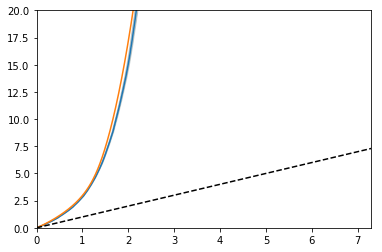

In [4]:
# params1 - standard causal mixture model, fit using old implementation
parametrization = precimed.mixer.utils.UnivariateParametrization_natural_axis(lib=libbgmg, trait=1)
bounds_left = UnivariateParams(pi=5e-5, sig2_beta=5e-6, sig2_zero=0.9)
bounds_right = UnivariateParams(pi=5e-1, sig2_beta=5e-2, sig2_zero=2.5)
params1=perform_fit(bounds_left, bounds_right, parametrization)
do_plots(params1, '_params1')



In [13]:
# params3 - infinitesimal model (just to find baseline sig2beta)
constraint = AnnotUnivariateParams(pi=1, sig2_annot=[1], s=0, l=0, annomat=annomat[:, 0].reshape(-1, 1), annonames=[annonames[0]], mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(sig2_beta=5e-8, sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(sig2_beta=5e-2, sig2_zeroA=2.5)
params3=perform_fit(bounds_left, bounds_right, parametrization)


AnnotUnivariateParams(_pi: [1], _sig2_beta: [6.534330016229654e-08], _sig2_annot: [1], _s: 0, _l: 0, _sig2_zeroA: 1.2382474823918246)
AnnotUnivariateParams(_pi: [1], _sig2_beta: [6.280174165299782e-08], _sig2_annot: [1], _s: 0, _l: 0, _sig2_zeroA: 1.2231983439793324)


/home/oleksanf/github/mixer/precimed/mixer/utils.py:815: RuntimeWarning: divide by zero encountered in log10
  data_x=-np.log10(np.flip(np.cumsum(np.flip(data_weights[si]))))     # step 2
/home/oleksanf/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/oleksanf/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/oleksanf/github/mixer/precimed/mixer/figures.py:44: RuntimeWarning: invalid value encountered in sqrt
  q = 10**-data_logpvec; dq= 1.96*np.sqrt(q*(1-q)/qq['sum_data_weights']);


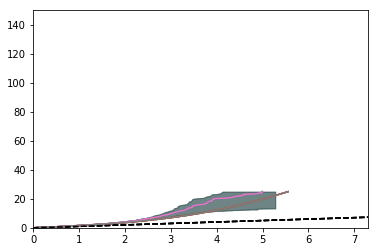

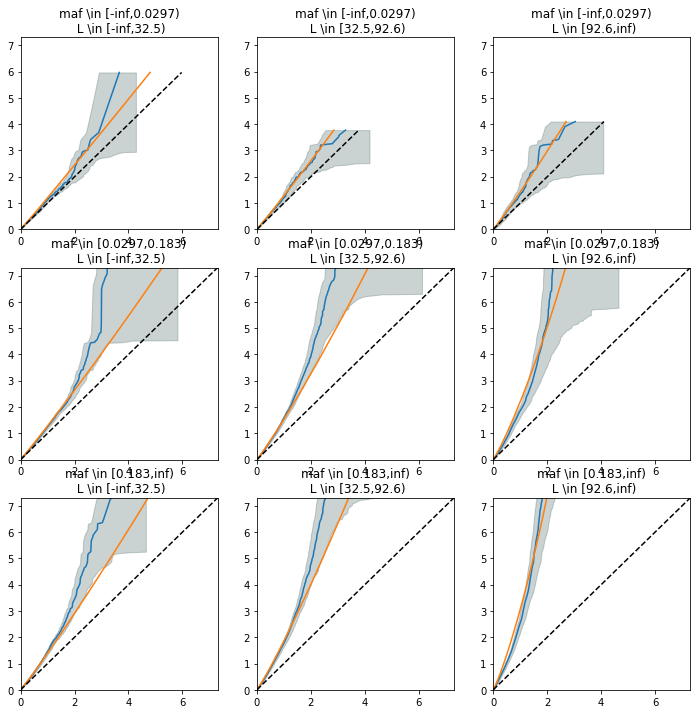

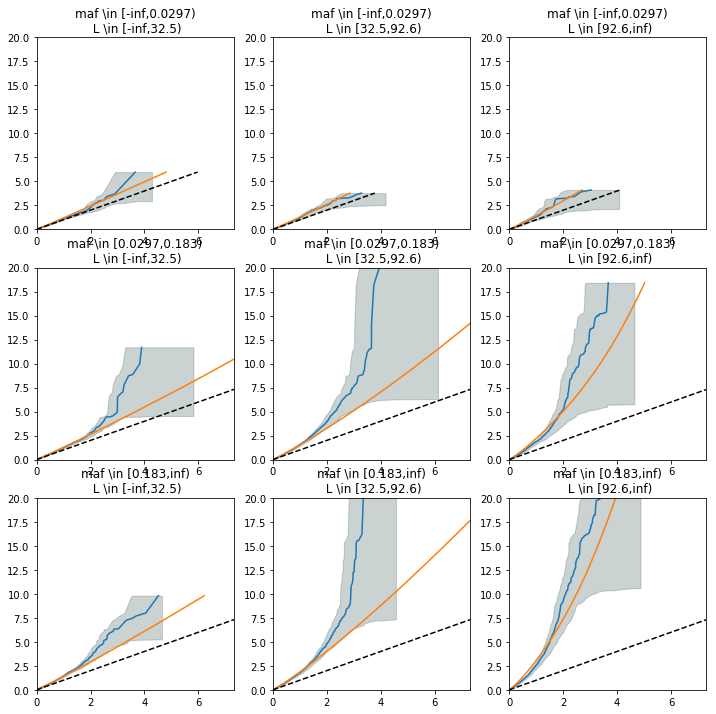

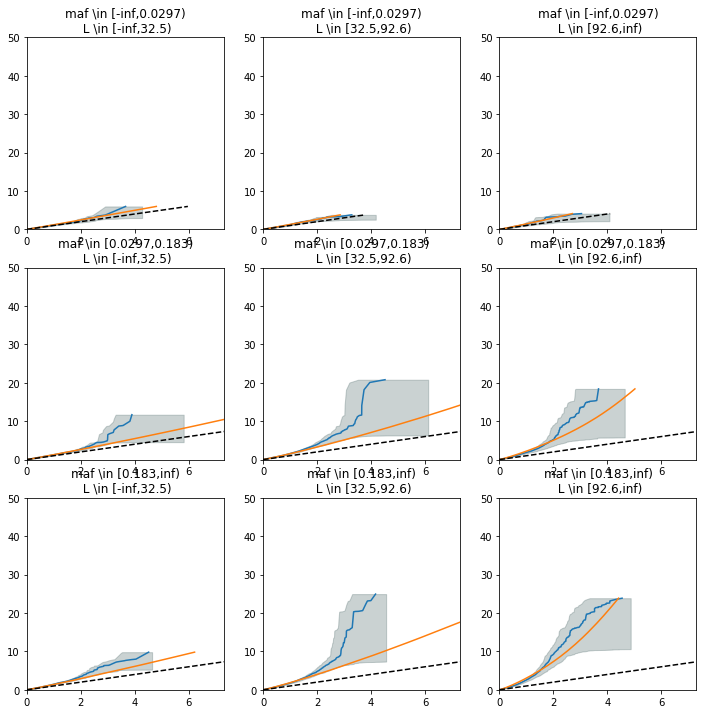

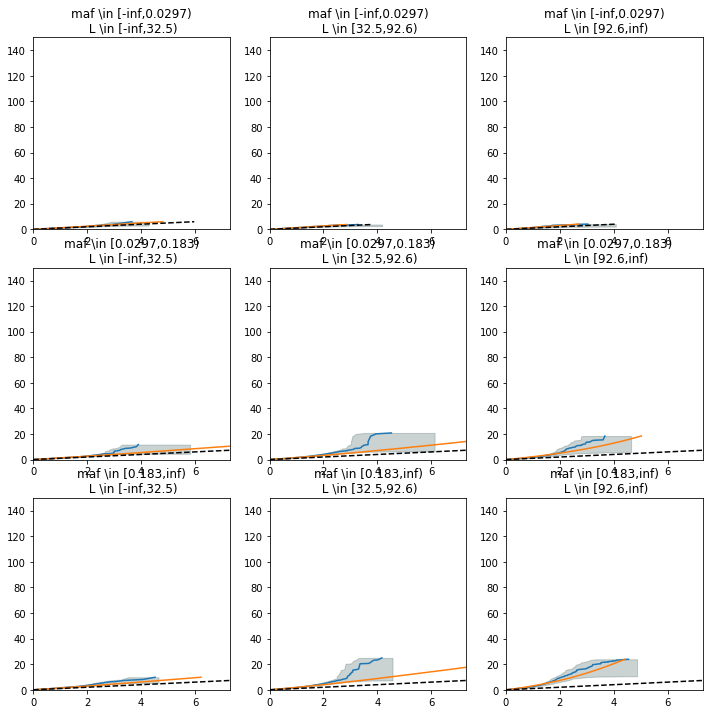

In [14]:
do_plots(params3, '_params3')

In [65]:
# params4 - infinitesimal model, allowing for flexible s and l parameters
constraint = AnnotUnivariateParams(pi=1, sig2_annot=[1], annomat=annomat[:, 0].reshape(-1, 1), annonames=[annonames[0]], mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(s=-1.0, l=-1.0, sig2_beta=5e-8, sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(s=0.25, l=0.25, sig2_beta=5e-2, sig2_zeroA=2.5)
params4=perform_fit(bounds_left, bounds_right, parametrization)


AnnotUnivariateParams(_pi: 1, _sig2_beta: 6.75500989148921e-07, _sig2_annot: [1], _s: -0.011335565551680804, _l: -0.16934948578635015, _sig2_zeroA: 2.054008709175631)
AnnotUnivariateParams(_pi: 1, _sig2_beta: 7.53163000205981e-07, _sig2_annot: [1], _s: -0.11721239089931484, _l: -0.22317196090908997, _sig2_zeroA: 2.0661803442547924)


In [71]:
# params5 - baseline annotation model, infinitesimal, without accounting for S and L parameters
trait_index=1
params5 = AnnotUnivariateParams(pi=1.0, sig2_beta=params3._sig2_beta, sig2_annot=None, annomat=annomat, annonames=annonames, s=0, l=0, sig2_zeroA=0, mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
params5.fit_sig2_annot(libbgmg, trait_index)
params5.drop_zero_annot()
print(params5)

AnnotUnivariateParams(_pi: 1.0, _sig2_beta: 2.9443784386506135e-07, _sig2_annot: [ 0.77784255 11.55259889  1.36064189  0.04819482  0.05711198  1.86221487
  2.24970066  0.64362227  0.14398438  0.22548616  2.03233305  3.50915398], _s: 0, _l: 0, _sig2_zeroA: 2.3190660353261126)


In [76]:
#params6 - baseline annotation model, infinitesimal, allowing for flexible S and L parameters
trait_index=1
params6 = AnnotUnivariateParams(pi=1.0, sig2_beta=params4._sig2_beta, sig2_annot=None, annomat=annomat, annonames=annonames, s=params4._s, l=params4._l, sig2_zeroA=0, mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
params6.fit_sig2_annot(libbgmg, trait_index)
params6.drop_zero_annot()
print(params6)

AnnotUnivariateParams(_pi: 1.0, _sig2_beta: 7.53163000205981e-07, _sig2_annot: [ 0.80677047 10.9351042   2.24750116  1.36860802  0.52322939  0.04378
  0.29449296  0.78957198 14.05955733  0.28672715], _s: -0.11721239089931484, _l: -0.22317196090908997, _sig2_zeroA: 1.7988296958524468)


AnnotUnivariateParams(_pi: 0.020112336745176665, _sig2_beta: 1.9934921745404774e-05, _sig2_annot: [ 0.77784255 11.55259889  1.36064189  0.04819482  0.05711198  1.86221487
  2.24970066  0.64362227  0.14398438  0.22548616  2.03233305  3.50915398], _s: 0, _l: 0, _sig2_zeroA: 2.010107269906994)
AnnotUnivariateParams(_pi: 0.016490772435950134, _sig2_beta: 2.1573172356293674e-05, _sig2_annot: [ 0.77784255 11.55259889  1.36064189  0.04819482  0.05711198  1.86221487
  2.24970066  0.64362227  0.14398438  0.22548616  2.03233305  3.50915398], _s: 0, _l: 0, _sig2_zeroA: 1.9785604206089915)


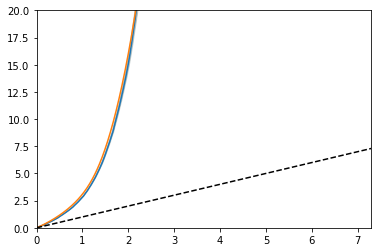

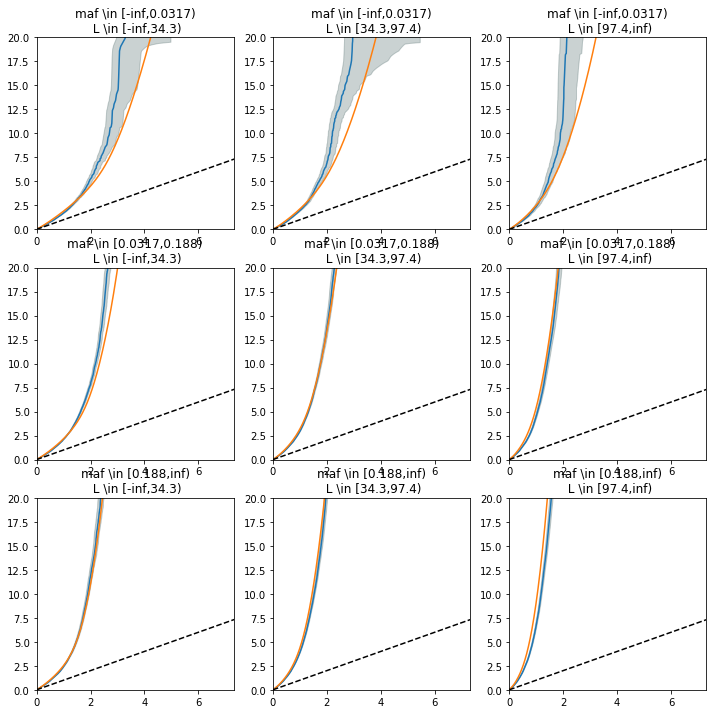

In [82]:
# params7 - causal mixture with annotation, without accounting for S and L parameters
constraint = AnnotUnivariateParams(s=0, l=0, sig2_annot=params5._sig2_annot, annomat=params5._annomat, annonames=params5._annonames, mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(pi=5e-5, sig2_beta=5e-6, sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(pi=5e-1, sig2_beta=5e-2, sig2_zeroA=2.5)
params7=perform_fit(bounds_left, bounds_right, parametrization)
do_plots(params7, '_params7', True)

AnnotUnivariateParams(_pi: 0.015785388620568757, _sig2_beta: 4.874428472741427e-05, _sig2_annot: [ 0.80677047 10.9351042   2.24750116  1.36860802  0.52322939  0.04378
  0.29449296  0.78957198 14.05955733  0.28672715], _s: -0.11721239089931484, _l: -0.22317196090908997, _sig2_zeroA: 1.886429562529495)
AnnotUnivariateParams(_pi: 0.015785512563498437, _sig2_beta: 4.5576351979317775e-05, _sig2_annot: [ 0.80677047 10.9351042   2.24750116  1.36860802  0.52322939  0.04378
  0.29449296  0.78957198 14.05955733  0.28672715], _s: -0.11721239089931484, _l: -0.22317196090908997, _sig2_zeroA: 1.9063891647797888)


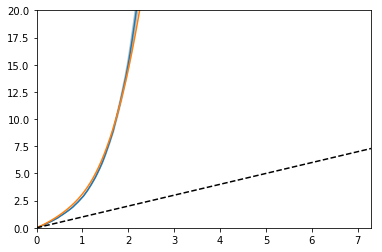

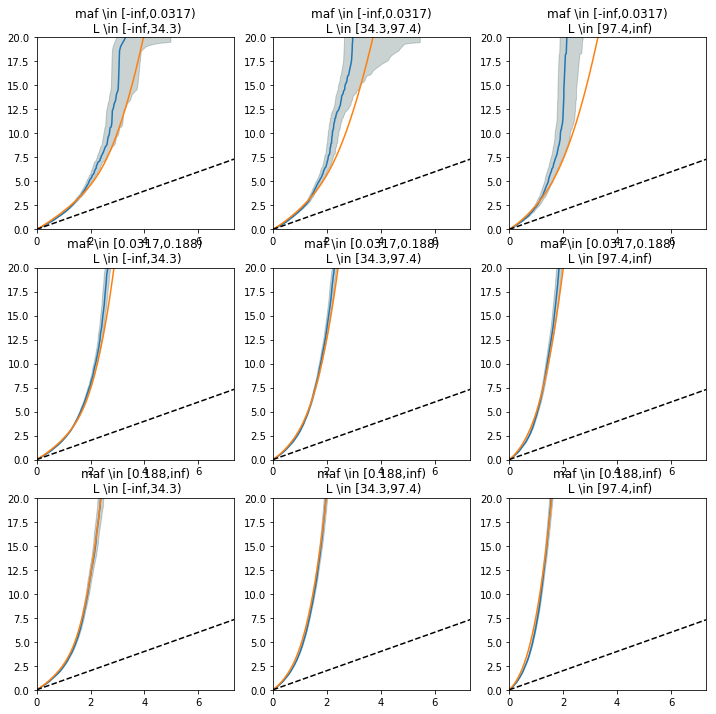

In [81]:
# params8 (6)  - causal mixture with annotation, allowing for flexible S and L parameters
constraint = AnnotUnivariateParams(s=params6._s, l=params6._l, sig2_annot=params6._sig2_annot, annomat=params6._annomat, annonames=params6._annonames, mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(pi=5e-5, sig2_beta=5e-6, sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(pi=5e-1, sig2_beta=5e-2, sig2_zeroA=2.5)
params8=perform_fit(bounds_left, bounds_right, parametrization)
do_plots(params8, '_params8', True)

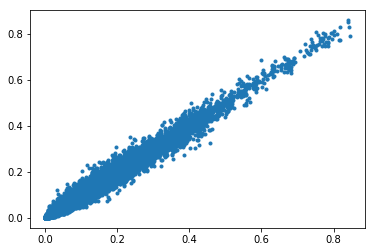

In [25]:
libbgmg = precimed.mixer.libbgmg.LibBgmg('/home/oleksanf/github/mixer/src/build/lib/libbgmg.so', dispose=False)
c0u,c1u,c2u = libbgmg.calc_unified_univariate_delta_posterior(1, pi_mat, sig2_mat, params9._sig2_zeroA, sig2_zeroC=1, sig2_zeroL=0)
c0,c1,c2 = libbgmg.calc_univariate_delta_posterior(1, params9._pi[0], params9._sig2_zeroA, params9._sig2_beta[0])

plt.plot(c2, c2u, '.')


In [32]:
libbgmg.weights.sum()


9275.8125

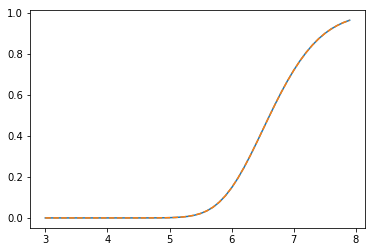

In [36]:
libbgmg = precimed.mixer.libbgmg.LibBgmg('/home/oleksanf/github/mixer/src/build/lib/libbgmg.so', dispose=False)
power_nvec, power_svec1 = precimed.mixer.utils.calc_power_curve(libbgmg, params9, trait_index=1, downsample=1)

params9_old = UnivariateParams(pi=params9._pi[0], sig2_beta=params9._sig2_beta[0], sig2_zero=params9._sig2_zeroA)
_, power_svec2 = precimed.mixer.utils.calc_power_curve(libbgmg, params9_old, trait_index=1, downsample=1)

plt.plot(np.log10(power_nvec), power_svec1)
plt.plot(np.log10(power_nvec), power_svec2, '--')


AnnotUnivariateParams(_pi: [0.0029543806646680246], _sig2_beta: [1.6388661486125145e-05], _sig2_annot: [1], _s: 0, _l: 0, _sig2_zeroA: 1.1975626969086972)
AnnotUnivariateParams(_pi: [0.004300714548333941], _sig2_beta: [1.4122377022132362e-05], _sig2_annot: [1], _s: 0, _l: 0, _sig2_zeroA: 1.2408333573346944)


/home/oleksanf/github/mixer/precimed/mixer/utils.py:823: RuntimeWarning: divide by zero encountered in log10
  data_x=-np.log10(np.flip(np.cumsum(np.flip(data_weights[si]))))     # step 2
/home/oleksanf/github/mixer/precimed/mixer/figures.py:50: RuntimeWarning: invalid value encountered in less
  y2[x2<np.nanmax(x1)]=interp1d(x1, y1)(x2[x2<np.nanmax(x1)])                #upper CI bound
/home/oleksanf/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/oleksanf/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/oleksanf/github/mixer/precimed/mixer/figures.py:44: RuntimeWarning: invalid value encountered in sqrt
  q = 10**-data_logpvec; dq= 1.96*np.sqrt(q*(1-q)/qq['sum_data_weights']);


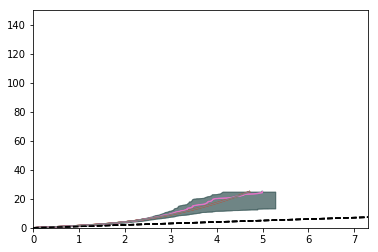

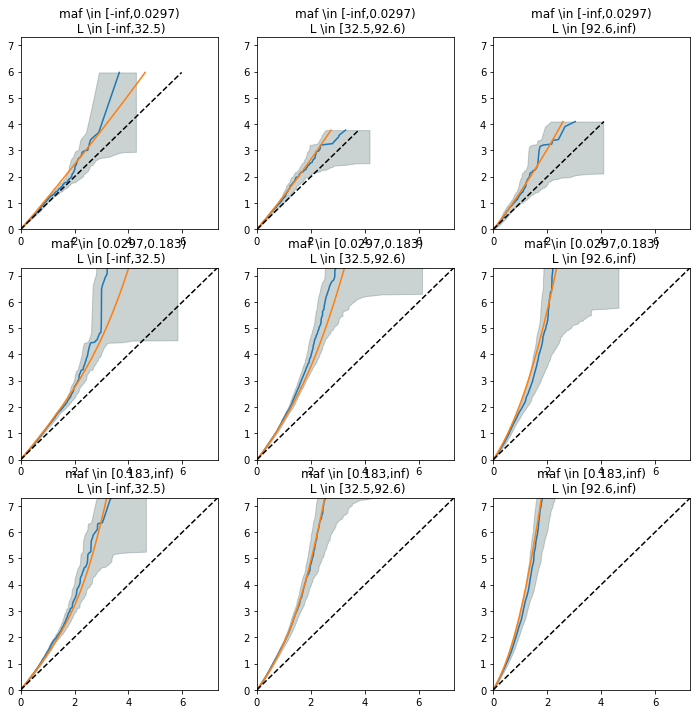

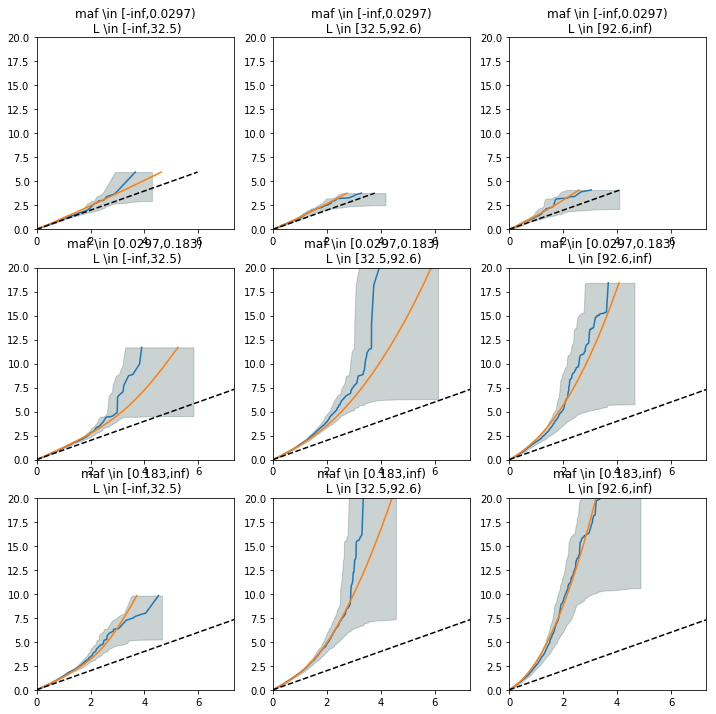

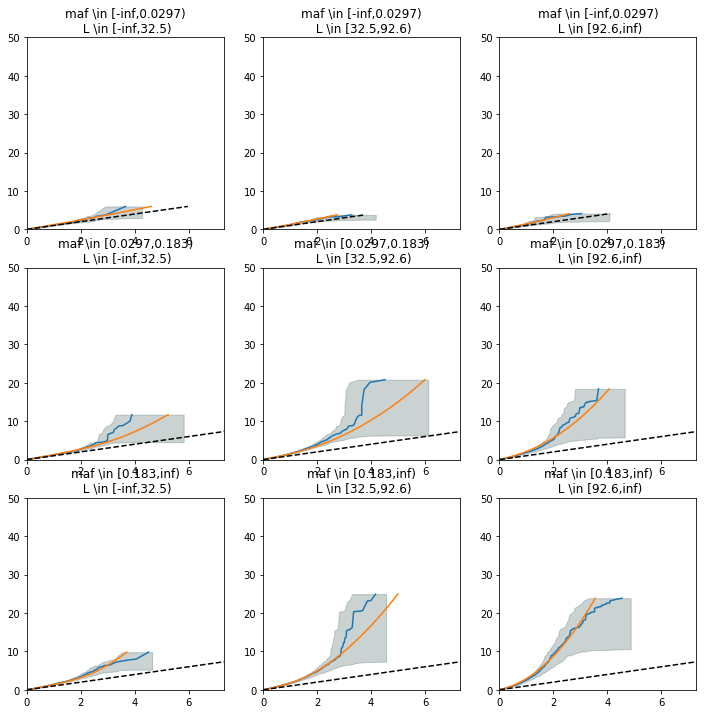

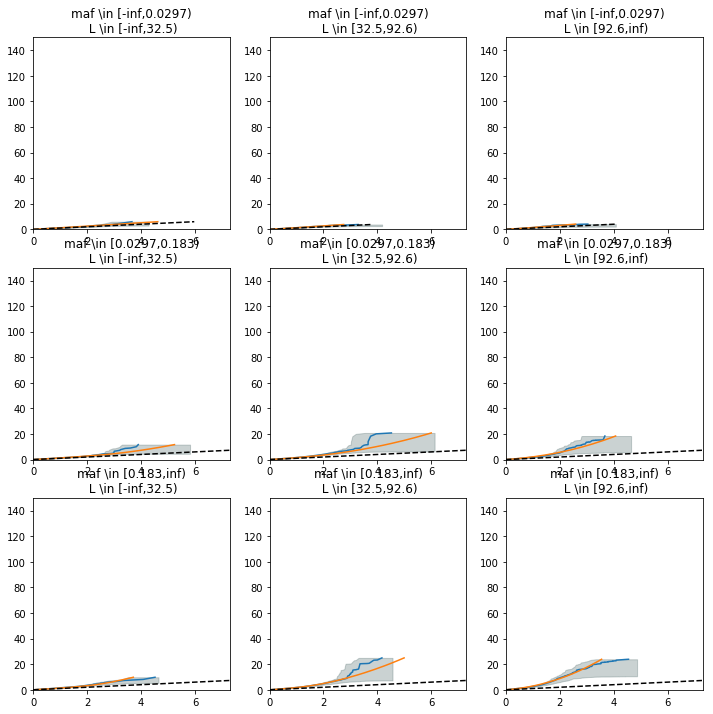

In [28]:

# params9 - causal mixture without annotations, without accounting for S and L parameters
constraint = AnnotUnivariateParams(sig2_annot=[1], s=0, l=0, annomat=annomat[:, 0].reshape(-1, 1), annonames=[annonames[0]], mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(pi=5e-5, sig2_beta=5e-6, sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(pi=5e-1, sig2_beta=5e-2, sig2_zeroA=2.5)
params9=perform_fit(bounds_left, bounds_right, parametrization)


do_plots(params9, '_params9')

In [29]:
libbgmg.set_option('cost_calculator', _cost_calculator_gaussian)
tag_pdf_gaussian=params9.tag_pdf(libbgmg, 1)

In [16]:
libbgmg.set_option('cost_calculator', _cost_calculator_sampling)
tag_pdf_sampling=params9.tag_pdf(libbgmg, 1)

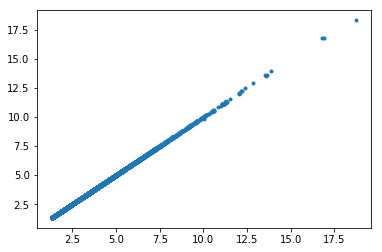

In [24]:
plt.plot(-np.log(tag_pdf_sampling[libbgmg.weights>0]), -np.log(tag_pdf_convolve[libbgmg.weights>0]), '.')
#plt.plot(-np.log(tag_pdf_gaussian[libbgmg.weights>0]), -np.log(tag_pdf_convolve[libbgmg.weights>0]), '.')
#plt.plot(tag_pdf_gaussian[libbgmg.weights>0], tag_pdf_convolve[libbgmg.weights>0], '.')

In [9]:
libbgmg.set_option('cost_calculator', _cost_calculator_sampling)
libbgmg.set_option('kmax', 20000)
for seed in range(1,10):
    libbgmg.set_option('seed', seed)
    print(seed, params9.cost(libbgmg, 1))


1 16792.106170893097
2 16791.890650355457
3 16791.813032662463
4 16792.353774611693


KeyboardInterrupt: 

In [13]:
z=np.abs(libbgmg.zvec1)
z=z[np.isfinite(z)]
z.max()

32.823

In [15]:
libbgmg.set_option('cost_calculator', _cost_calculator_convolve)
#print(seed, params9.cost(libbgmg, 1))
tag_pdf_convolve=params9.tag_pdf(libbgmg, 1)

AnnotUnivariateParams(_pi: 0.0019422768605894315, _sig2_beta: 0.0001514049546435859, _sig2_annot: [1], _s: -0.6445122556819146, _l: -0.1664666397153803, _sig2_zeroA: 2.1554019231845993)
AnnotUnivariateParams(_pi: 0.0017433067614436263, _sig2_beta: 0.00032365469994769143, _sig2_annot: [1], _s: -0.4346094933177381, _l: -0.25205482692795367, _sig2_zeroA: 2.1819290510636007)


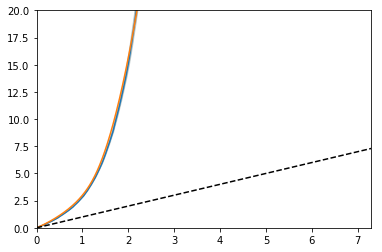

In [114]:
# params10 - causal mixture without annotations, allowing for flexible S and L parameters
constraint = AnnotUnivariateParams(sig2_annot=[1], annomat=annomat[:, 0].reshape(-1, 1), annonames=[annonames[0]], mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(s=-1.0, l=-1.0, pi=5e-5, sig2_beta=5e-6, sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(s=0.25, l=0.25, pi=5e-1, sig2_beta=5e-2, sig2_zeroA=2.5)
params10=perform_fit(bounds_left, bounds_right, parametrization)
do_plots(params10, '_params10', True)

In [124]:
# params11  (6)  causal mixture with annotations, allowing for flexible S and L parameters,
#                and re-fit S and L in the context of mixture model
constraint = AnnotUnivariateParams(sig2_annot=params6._sig2_annot, annomat=params6._annomat, annonames=params6._annonames, mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(s=-1.0, l=-1.0, pi=5e-5, sig2_beta=5e-6, sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(s=0.25, l=0.25, pi=5e-1, sig2_beta=5e-2, sig2_zeroA=2.5)
params11=perform_fit(bounds_left, bounds_right, parametrization)


AnnotUnivariateParams(_pi: 0.014591266436314046, _sig2_beta: 2.5377289052973313e-05, _sig2_annot: [ 0.80677047 10.9351042   2.24750116  1.36860802  0.52322939  0.04378
  0.29449296  0.78957198 14.05955733  0.28672715], _s: -0.4796922678191362, _l: -0.15359210045600655, _sig2_zeroA: 1.8451261379413293)
AnnotUnivariateParams(_pi: 0.015880541721926548, _sig2_beta: 2.2497055296175e-05, _sig2_annot: [ 0.80677047 10.9351042   2.24750116  1.36860802  0.52322939  0.04378
  0.29449296  0.78957198 14.05955733  0.28672715], _s: -0.365544728354278, _l: -0.13260565509183503, _sig2_zeroA: 1.8823111632885878)


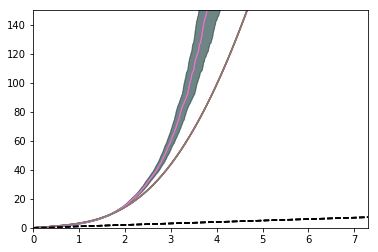

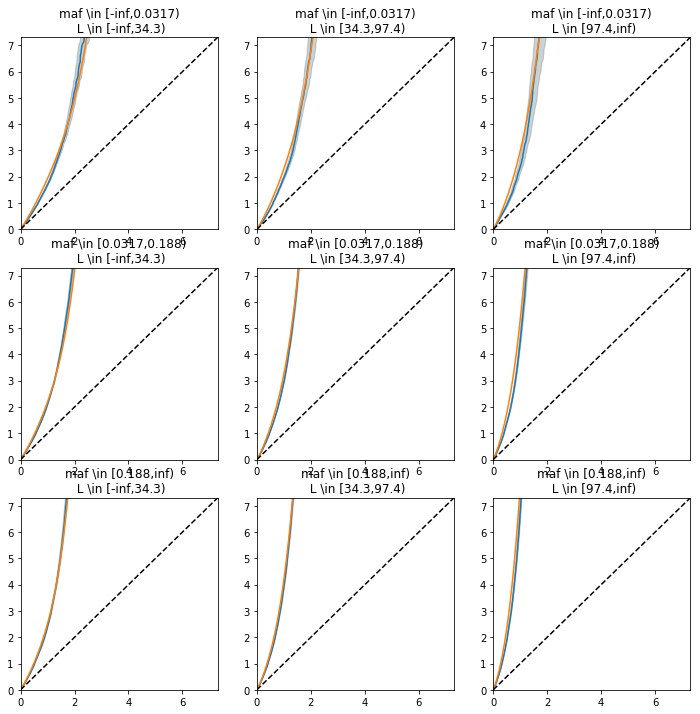

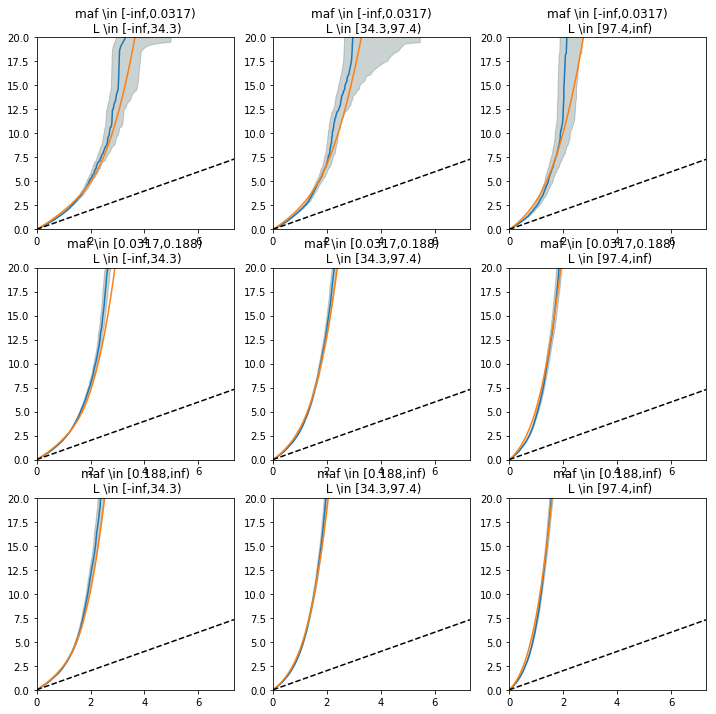

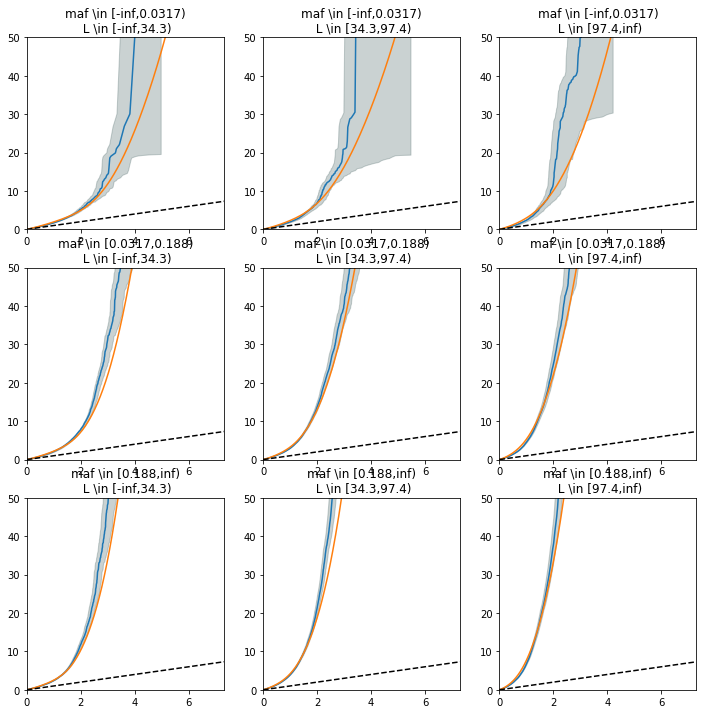

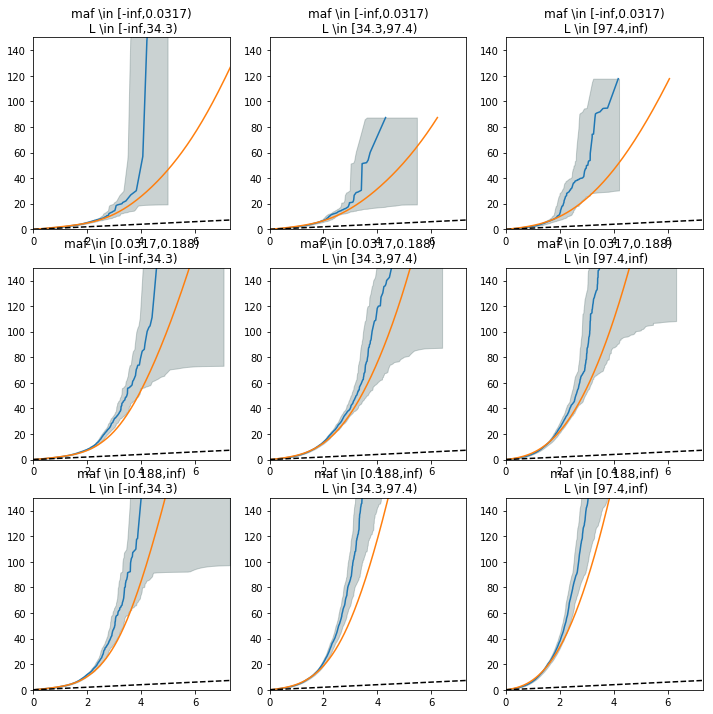

In [126]:
do_plots(params11, '_params11')

In [ ]:
# params21 - infinitesimal model (just to find baseline sig2beta)
constraint = AnnotUnivariateParams(pi=[None, None], sig2_beta=[None, None], sig2_annot=[1], s=0, l=0, annomat=annomat[:, 0].reshape(-1, 1), annonames=[annonames[0]], mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(pi=[5e-5, 5e-5], sig2_beta=[5e-8, 5e-8], sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(pi=[5e-1, 5e-1], sig2_beta=[5e-2, 5e-2], sig2_zeroA=2.5)
params21=perform_fit(bounds_left, bounds_right, parametrization)


In [573]:
# params20 - infinitesimal model (just to find baseline sig2beta)
constraint = AnnotUnivariateParams(pi=[1, None], sig2_beta=[None, None], sig2_annot=[1], s=0, l=0, annomat=annomat[:, 0].reshape(-1, 1), annonames=[annonames[0]], mafvec=libbgmg.mafvec, tldvec=libbgmg.ld_tag_r2_sum)
parametrization = precimed.mixer.utils.AnnotUnivariateParametrization(lib=libbgmg, trait=1, constraint=constraint)
bounds_left = AnnotUnivariateParams(pi=[None, 5e-5], sig2_beta=[5e-8, 5e-8], sig2_zeroA=0.9)
bounds_right = AnnotUnivariateParams(pi=[None, 5e-1], sig2_beta=[5e-2, 5e-2], sig2_zeroA=2.5)
params20=perform_fit(bounds_left, bounds_right, parametrization)


AnnotUnivariateParams(_pi: [1, 7.402682974759894e-05], _sig2_beta: [2.7914417333806207e-07, 0.0009516113053639361], _sig2_annot: [1], _s: 0, _l: 0, _sig2_zeroA: 2.016873888212911)
AnnotUnivariateParams(_pi: [1, 5.905602713600562e-05], _sig2_beta: [2.5857617302651813e-07, 0.001053370941930103], _sig2_annot: [1], _s: 0, _l: 0, _sig2_zeroA: 2.2396722377742737)


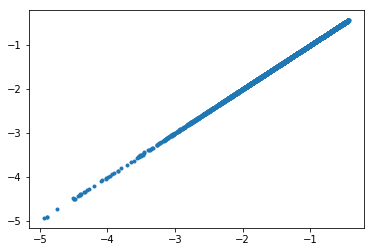

In [59]:
import json
fname = '/home/oleksanf/github/mixer/precimed/mixer.tmp.json'
pname = 'params3'
data = json.loads(open(fname).read())
#plt.plot(np.log10(data['params1']['power']['nvec']), data['params1']['power']['svec'])
s=data[pname]['sampling_tag_pdf']
g=data[pname]['gaussian_tag_pdf']
c=data[pname]['convolve_tag_pdf']
plt.plot(np.log10(s), np.log10(c), '.')

In [662]:
a=np.divide(full_err, full)
(~np.isfinite(full)).sum()

0

In [349]:
data['params1']['optimize'][1][1]['fun']

12270.056865402554

In [342]:
-np.sum(w*np.log(fast))

12270.056880216127

In [350]:
fname = '/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/UKB_HEIGHT_2018_irnt.outtag=run2.fit.json'
data = json.loads(open(fname).read())

In [353]:
len(data['weights'])

1040631

In [438]:
weights = np.array(data['weights'])

mask = weights>0
for params in ['params1', 'params2', 'params5', 'params6', 'params50']:
    full = np.array(data[params]['full_tag_pdf'])
    fast = np.array(data[params]['fast_tag_pdf'])
    diff=(np.abs(np.log(full)-np.log(fast)))
    mask[~np.isfinite(full) | (diff>1e-5)] = False
    print(np.sum(mask==False))
for params in ['params3', 'params4', 'params7', 'params8', 'params9', 'params51', 'params52']:
    full = np.array(data[params]['full_tag_pdf'])
    fast = np.array(data[params]['fast_tag_pdf'])
    mask[~np.isfinite(full)] = False
    print(np.sum(mask==False))
for params in ['params3', 'params4', 'params7', 'params8', 'params9', 'params51', 'params52']:
    full = np.array(data[params]['full_tag_pdf'])
    fast = np.array(data[params]['fast_tag_pdf'])
    diff=(np.abs(np.log(full)-np.log(fast)))
    print(np.max(diff[mask]), -np.dot(weights[mask], np.log(fast[mask])), -np.dot(weights[mask], np.log(full[mask])))
    
if 0:

    print(-np.dot(weights, np.log(fast)), data['params1']['optimize'][1][1]['fun'])
    diff=(np.abs(np.log(full)-np.log(fast)))
    print(np.sum(diff>0.001))

    full2 = np.array(data['params2']['full_tag_pdf'])
    fast2 = np.array(data['params2']['fast_tag_pdf'])


/home/oleksanf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


1685
2431
2694
2846
2846
2846
2846
2846
2846
3.406898595921861 214683.36484244416 214423.72249304948
4.417584384172022 214526.17906430885 214307.73439024464
3.6948307848314403 212945.93877034655 212376.76623557456
4.413854023448712 212950.60080635376 212368.9989489987
4.410832583741891 212878.78043164103 212319.15092463273


/home/oleksanf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


In [388]:
np.sum(diff>0.0001)

570

In [398]:
np.max(diff2[np.isfinite(diff2)])

49.21477645403603

In [414]:
diff2=(np.abs(np.log(np.array(data['params6']['full_tag_pdf']))-np.log(np.array(data['params6']['fast_tag_pdf']))))
np.max(diff2[np.isfinite(diff2) &  (diff<1e-7)])

/home/oleksanf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


11.90894581763056

In [420]:
np.sum(diff>1e-4)

570

In [49]:
trait='PGC_SCZ_2014_EUR'
#df=pd.read_table('/home/oleksanf/vmshare/data/MMIL/ANALYSIS/{}.partitioned_h2.results'.format(trait),sep='\t')
df=pd.DataFrame({'annonames':data['options']['annonames']})
fname = '/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/{}.outtag=run4.fit.json'.format(trait)
data = json.loads(open(fname).read())
    
for i in list(range(1, 10)) + [50, 51, 52]:
    if 'params{}'.format(i) not in data: continue
    df['params{}'.format(i)] = np.array(data['params{}'.format(i)]['annot_enrich'])
df.to_csv('/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/annot_enrich_ASchork_{}.csv'.format(trait),index=False,sep='\t')

In [71]:

plsa_folder = '/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/'
#fname='GIANT_HEIGHT_2018_UKB'; data=json.loads(open(plsa_folder + fname + '.models=3.outtag=run7.fit.json').read())
fname='PGC_SCZ_2014_EUR'; data=json.loads(open(plsa_folder + fname+'.models=3.outtag=run8.fit.json').read())
#fname='PGC_BIP_2016'; data=json.loads(open(plsa_folder + fname +'.models=4.outtag=run7.fit.json').read())

In [69]:
data['params3'].keys()

dict_keys(['params', 'optimize', 'annot_enrich', 'annot_h2', 'convolve_tag_pdf', 'convolve_tag_pdf_err', 'sampling_tag_pdf', 'gaussian_tag_pdf', 'qqplot', 'qqplot_bins'])

In [ ]:
HEIGHT 3,7,8
BIP 3,4,7,8
SCZ 3,4,7,8
EDU 3,7,8

{'pi': [0.004201028586457496], 'sig2_beta': [5.18894008601531e-05], 'sig2_zeroA': 1.172034736090368, 's': 0, 'l': 0, 'sig2_annot': [1], 'annonames': ['base']}
{'pi': [0.003792662009069121], 'sig2_beta': [5.777405767346033e-05], 'sig2_zeroA': 1.1705578313883305, 's': 0, 'l': 0, 'sig2_annot': [1], 'annonames': ['base']}
{'pi': [0.004214757372085943], 'sig2_beta': [5.170773994399179e-05], 'sig2_zeroA': 1.1720225315059574, 's': 0, 'l': 0, 'sig2_annot': [1], 'annonames': ['base']}
{'pi': [0.003791127922836069], 'sig2_beta': [5.779377158997732e-05], 'sig2_zeroA': 1.1705648868404, 's': 0, 'l': 0, 'sig2_annot': [1], 'annonames': ['base']}


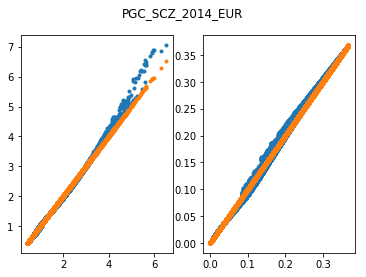

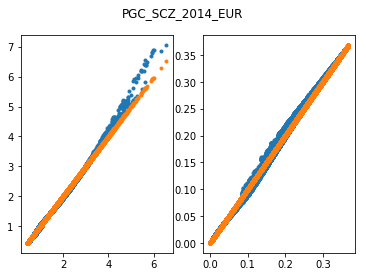

In [75]:
fname='PGC_SCZ_2014_EUR'; data=json.loads(open(plsa_folder + fname+'.models=3.outtag=run7.fit.json').read())

plt.figure()
p0=data['params3']['sampling_tag_pdf']
p1=data['params3']['gaussian_tag_pdf']
p2=data['params3']['convolve_tag_pdf']
plt.subplot(1,2,1);plt.plot(-np.log10(p0), -np.log10(p1), '.');plt.plot(-np.log10(p0), -np.log10(p2), '.')
plt.subplot(1,2,2);plt.plot(p0, p1, '.');plt.plot(p0, p2, '.');plt.suptitle(fname);
print(data['params3']['optimize'][1][1]['params'])
print(data['params3']['optimize'][2][1]['params'])

plt.figure()
fname='PGC_SCZ_2014_EUR'; data=json.loads(open(plsa_folder + fname + '.models=3.outtag=run8.fit.json').read())
p0=data['params3']['sampling_tag_pdf']
p1=data['params3']['gaussian_tag_pdf']
p2=data['params3']['convolve_tag_pdf']
plt.subplot(1,2,1);plt.plot(-np.log10(p0), -np.log10(p1), '.');plt.plot(-np.log10(p0), -np.log10(p2), '.')
plt.subplot(1,2,2);plt.plot(p0, p1, '.');plt.plot(p0, p2, '.');plt.suptitle(fname);
print(data['params3']['optimize'][1][1]['params'])
print(data['params3']['optimize'][2][1]['params'])

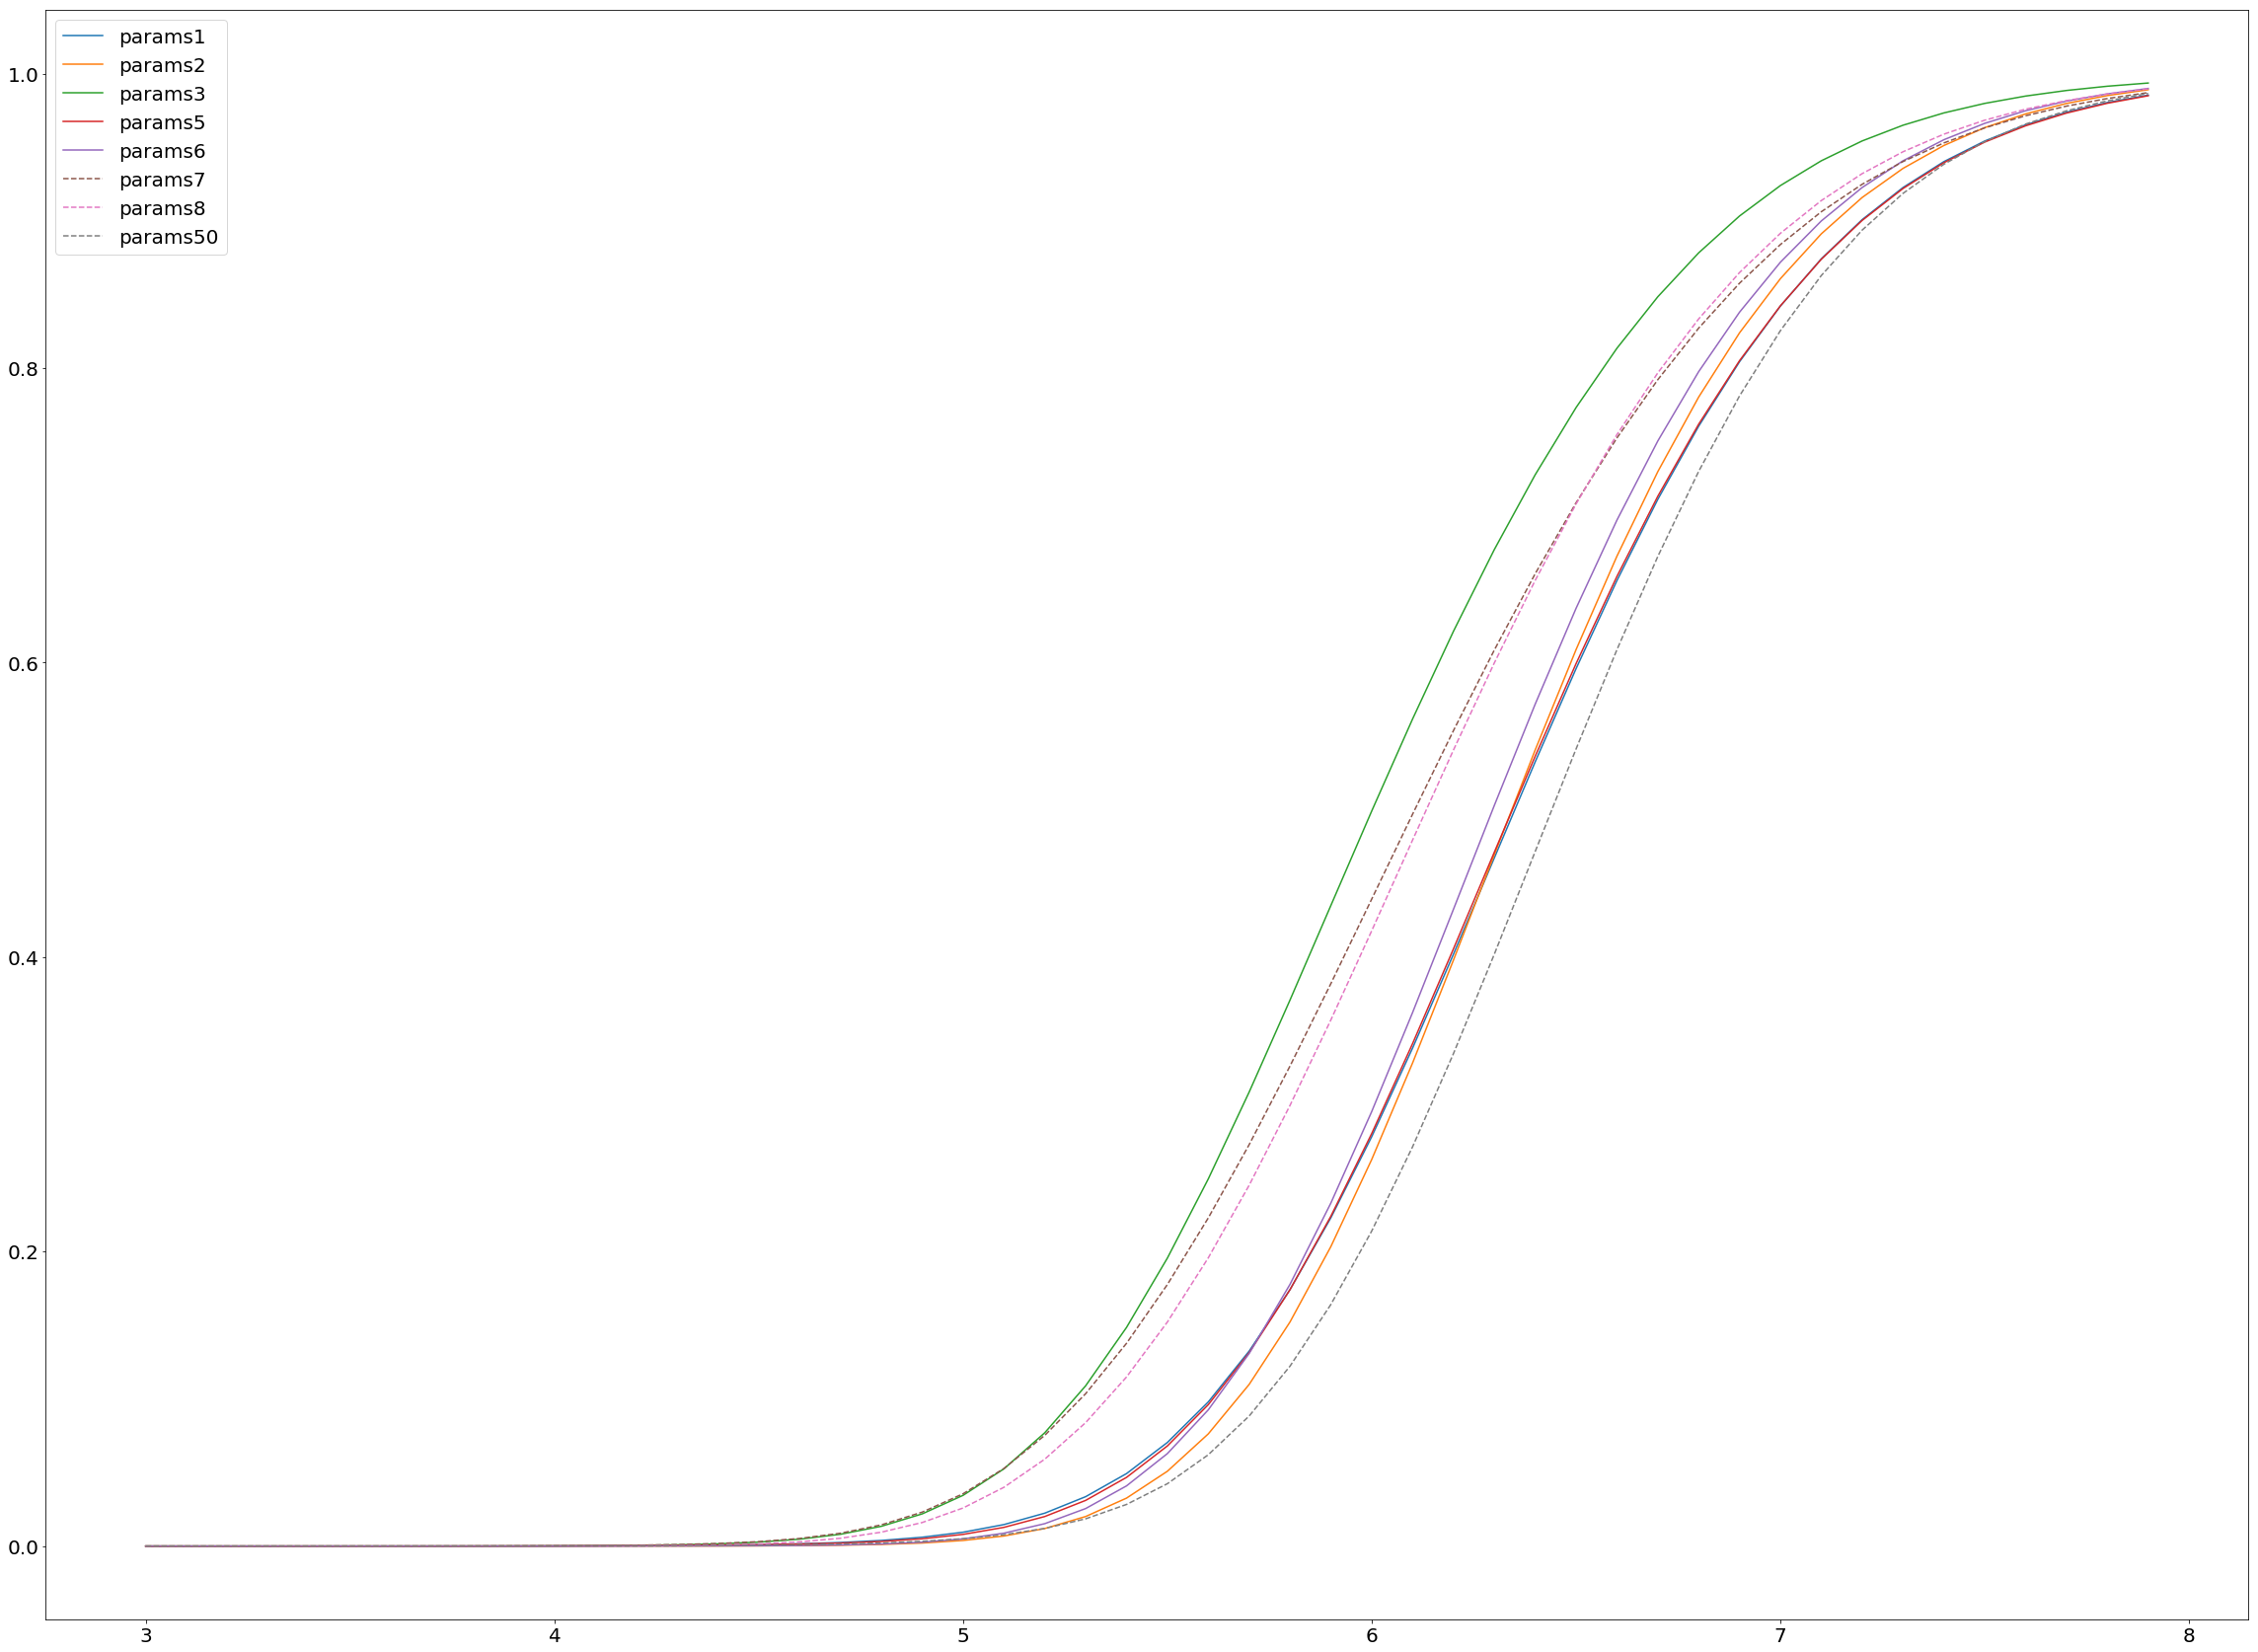

In [97]:
fig=plt.figure(figsize=[40, 30])
legends=[]
for index, i in enumerate(list(range(1, 10)) + [50, 51,52]):
    kind='params{}'.format(i)
    if kind not in data: continue
    plt.plot(np.log10(data[kind]['power']['nvec']), data[kind]['power']['svec'], linestyle='solid' if index<6 else 'dashed')
    legends.append(kind)
plt.legend(legends)

In [30]:
data_tmp = json.loads(open('/home/oleksanf/github/mixer/precimed/mixer.json').read())
data_tmp['m03']['optimize_s']

[['diffevo-fast',
  {'x': [-15.642787878756575, 0.1151485786444818],
   'fun': 15173.58464507732,
   'nfev': 210,
   'nit': 6,
   'message': 'Optimization terminated successfully.',
   'success': True,
   'cost_n': 9653.984375,
   'cost_df': 2,
   'cost': 15173.58464507732,
   'BIC': 30365.51954230613,
   'AIC': 30351.16929015464,
   'cost_fast': 15173.584645077322,
   'params': {'pi': [1],
    'sig2_beta': [1.608509175722143e-07],
    'sig2_zeroA': 1.1220401363902084,
    's': -0.5,
    'l': 0,
    'sig2_annot': [1],
    'annonames': ['base']}}],
 ['nedlermead-fast',
  {'fun': 15173.497917256009,
   'nit': 24,
   'nfev': 51,
   'status': 0,
   'success': True,
   'message': 'Optimization terminated successfully.',
   'x': [-15.681217553594209, 0.12210286423160534],
   'final_simplex': [[[-15.681217553594209, 0.12210286423160534],
     [-15.681160139299744, 0.12210898495432682],
     [-15.681120319633523, 0.12209453035846861]],
    [15173.497917256009, 15173.497922948804, 15173.4979312

In [31]:
data['params']

{'pi': [0.22928301143666854, 0.004196627817437162],
 'sig2_beta': [3.2684861279713417e-09, 4.7015866287594755e-05],
 'sig2_zeroA': 1.1723446770374535,
 's': -0.06559127240374887,
 'l': 0.0062005329298866095,
 'sig2_annot': [0.9267094362721238],
 'annonames': ['base'],
 'C1frac': 0.0037837917763347845,
 'h2': 0.42323243618011475,
 'num_annot': 1,
 'model': 'm32_PPLSA',
 'fastcost': 151829.3706658403,
 'fullcost': nan,
 'nit': 510,
 'annots': 'base'}

In [29]:
data['spec']

'm32_PPLSA'

/home/oleksanf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in log


/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=52.outtag=run8.fit.json - exclude 807 SNPs from cost function, mean(|z|)=1.0093280566797893, #SNP(|z|>20)=0


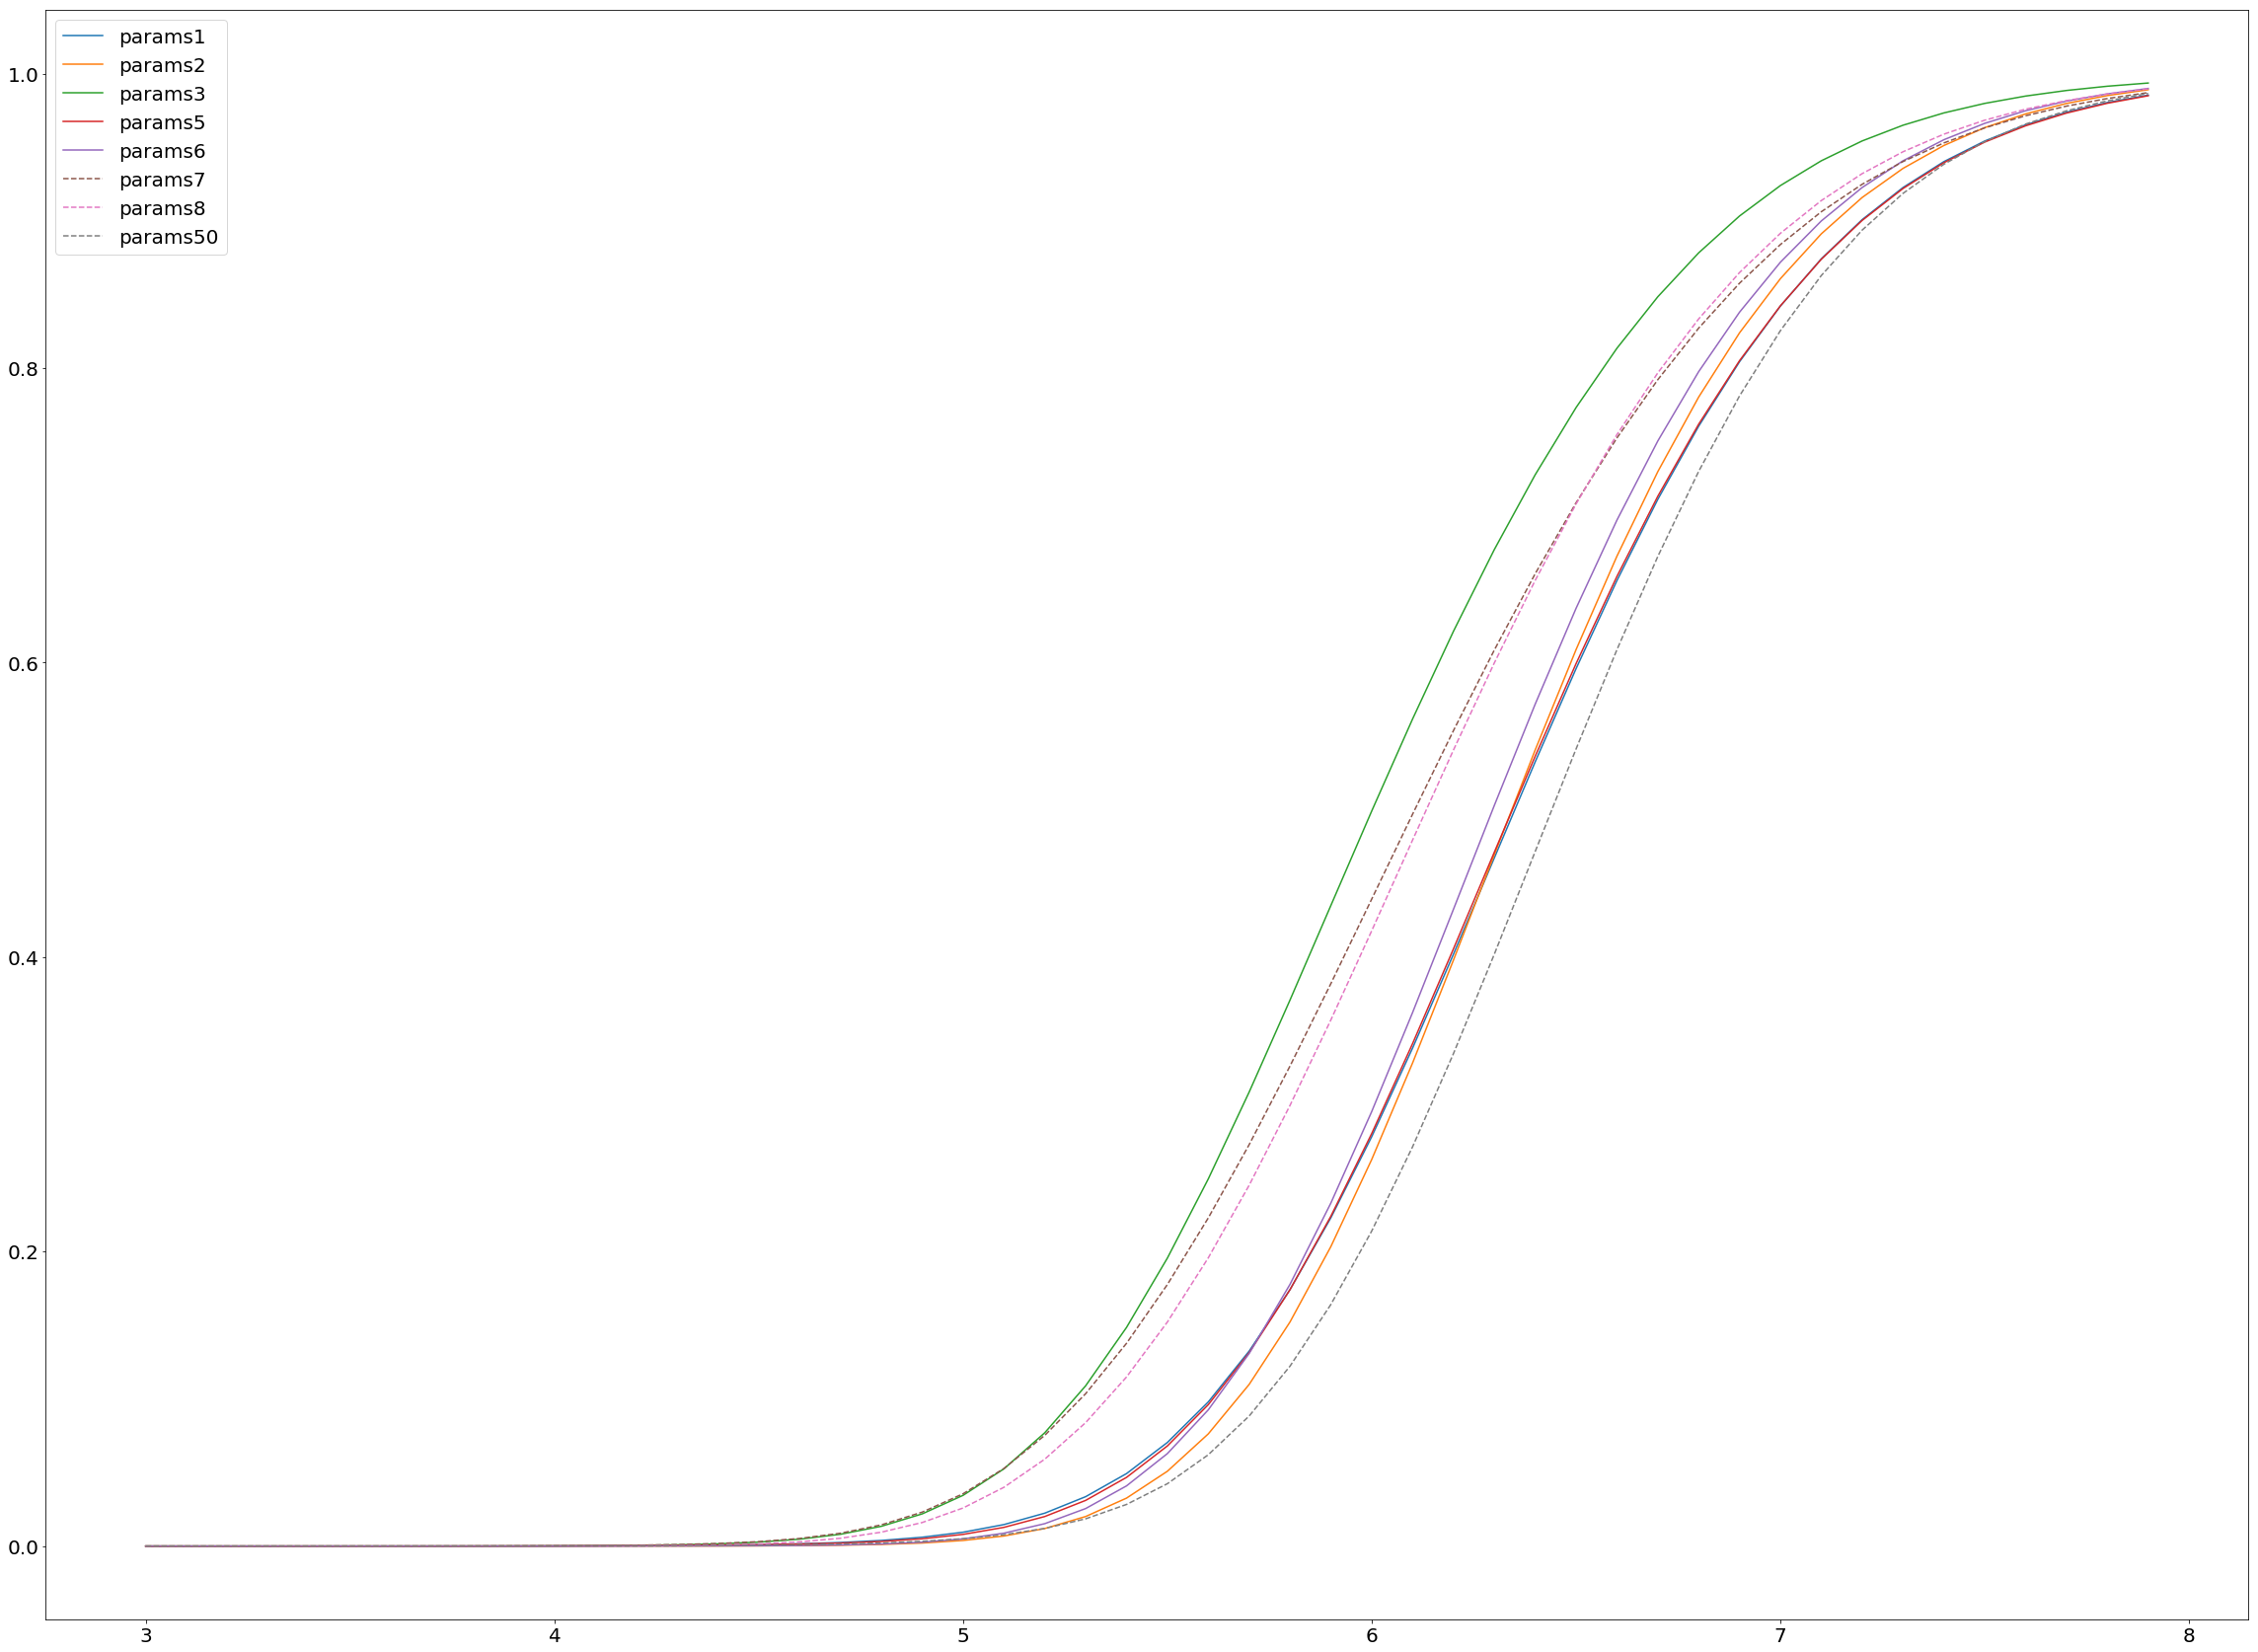

In [98]:
import json
import os

def insert_key_to_dictionary_as_list(key, value, df_data):
    if key not in df_data:
        df_data[key] = []
    df_data[key].append(value)

def make_qq_plot(qq, color, ylim=7.3, xlim=7.3):
    hv_logp = np.array(qq['hv_logp']).astype(float)
    data_logpvec = np.array(qq['data_logpvec']).astype(float)
    model_logpvec = np.array(qq['model_logpvec']).astype(float)
    ylim_data = max(hv_logp[np.isfinite(data_logpvec)])
    model_logpvec[hv_logp > ylim_data]=np.nan
    hData = plt.plot(data_logpvec, hv_logp, color=color, linestyle='solid')
    hModel = plt.plot(model_logpvec, hv_logp, color=color, linestyle='dashed')
    hNull = plt.plot(hv_logp, hv_logp, 'k--')
    plt.ylim(0, ylim); plt.xlim(0, xlim)
    return hData[0]

cm = plt.cm.get_cmap('tab10')
  
plt.rcParams.update({'mathtext.default': 'regular', 'font.size': 20 })

    
df_final=None
#traits=['CARDIOGRAM_CAD_2015', 'GIANT_BMI_2015_EUR', 'GIANT_HEIGHT_2018_UKB', 'IIBDGC_CD_2017', 'IIBDGC_UC_2017', 'LIPIDS_HDL_2013', 'LIPIDS_LDL_2013', 'LIPIDS_TG_2013', 'PGC_BIP_2016', 'PGC_SCZ_2014_EUR', 'SSGAC_EDU_2018_no23andMe', 'UKB_HEIGHT_2018_irnt' ]
#traits=[ 'GIANT_HEIGHT_2018_UKB','PGC_BIP_2016', 'PGC_SCZ_2014_EUR', 'SSGAC_EDU_2018_no23andMe', ]
traits=[ 'PGC_SCZ_2014_EUR' ]
for trait in traits:
    data = {}
    #fname = '/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/{}.outtag=run4.fit.json'.format(trait)
    #fname = '/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/{}.outtag=run2.fit.json'.format(trait)
    
    for i in list(range(1, 10)) + [50, 51, 52]:
        fname = '/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/{}.models={}.outtag=run8.fit.json'.format(trait, i)
        if (not os.path.exists(fname)) or (os.path.getsize(fname) == 0): continue
        data_tmp = json.loads(open(fname).read())
        if len(data) == 0: data=data_tmp
        else: data['params{}'.format(i)] = data_tmp['params{}'.format(i)]

    trait = fname.split('/')[-1].split('.')[0]
    has_zvec = 'zvec1' in data
    
    for ylim in []: #[7.3, 20, 50, 150]:
        fig=plt.figure(figsize=[40, 30])
        
        fig.suptitle(trait)
        for index, i in enumerate(list(range(1, 10)) + [50, 51,52]):
            kind='params{}'.format(i)
            if kind not in data: continue
            plt.subplot(3,4,index+1)
            plt.title(kind)
            h1=make_qq_plot(data[kind]['qqplot'], color=cm.colors[0], ylim=ylim)
            h2=make_qq_plot(data[kind]['qqplot_bins'][0], color=cm.colors[1], ylim=ylim)
            t1='low maf\nlow LD'#data[kind]['qqplot_bins'][0]['title'].replace('\\in', '').replace(';', '\n')
            h3=make_qq_plot(data[kind]['qqplot_bins'][8], color=cm.colors[2], ylim=ylim)
            t2='high maf\nhigh LD' # data[kind]['qqplot_bins'][8]['title'].replace('\\in', '').replace(';', '\n')
            plt.legend([h1, h2, h3], ['all', t1, t2])
        plt.savefig('/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/figures/' + trait + '.model={}'.format(i) + '.ylim={}.qq.png'.format(ylim) , bbox_inches='tight')

    if 1:
        fig=plt.figure(figsize=[40, 30])
        legends=[]
        for index, i in enumerate(list(range(1, 10)) + [50, 51,52]):
            kind='params{}'.format(i)
            if kind not in data: continue
            plt.plot(np.log10(data[kind]['power']['nvec']), data[kind]['power']['svec'], linestyle='solid' if index<6 else 'dashed')
            legends.append(kind)
        plt.legend(legends)
        plt.savefig('/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/figures/' + trait + '.power.png'.format(ylim) , bbox_inches='tight')
  
    # detect which SNPs lead to unreliable convolution cost function
    weights = np.array(data['weights'])
    mask = weights>0
    for params in ['params1', 'params2', 'params5', 'params6', 'params50']:
        if params not in data: continue
        full = np.array(data[params]['convolve_tag_pdf'])
        fast = np.array(data[params]['gaussian_tag_pdf'])
        diff=(np.abs(np.log(full)-np.log(fast)))
        mask[~np.isfinite(full) | (diff>1e-5)] = False
        #print(np.sum(mask==False))
    for params in ['params3', 'params4', 'params7', 'params8', 'params9', 'params51', 'params52']:
        if params not in data: continue
        full = np.array(data[params]['convolve_tag_pdf'])
        fast = np.array(data[params]['gaussian_tag_pdf'])
        mask[~np.isfinite(full)] = False
    if has_zvec:
        print('{} - exclude {} SNPs from cost function, mean(|z|)={}, #SNP(|z|>20)={}'.format(
            fname, np.sum(mask==False),
            np.mean(np.abs(np.array(data['zvec1'])[mask])),
            np.sum(np.abs(np.array(data['zvec1']))>20)))

    df_data = {}
    for i in list(range(1, 10)) + [50, 51, 52]:
        if 'params{}'.format(i) not in data: continue
        p = data['params{}'.format(i)]['params']
        full = np.array(data['params{}'.format(i)]['convolve_tag_pdf'])
        fast = np.array(data['params{}'.format(i)]['gaussian_tag_pdf'])

        p['C1frac'] = 1 if (isinstance(p['pi'], (int, float)) or (len(p['pi']) == 1)) else p['pi'][0]*p['sig2_beta'][0]/np.dot(p['pi'], p['sig2_beta'])
            
        p['h2'] = data['params{}'.format(i)]['annot_h2'][0]
        p['num_annot'] = len(p['annonames'])
        p['model'] = 'params{}'.format(i)
        p['fullcost'] = -np.dot(weights[mask], np.log(full[mask])) #data['params{}'.format(i)]['full_cost']
        not_has_optimize = not data['params{}'.format(i)]['optimize']
        p['fastcost'] = -np.dot(weights[mask], np.log(fast[mask])) # np.nan if not_has_optimize else data['params{}'.format(i)]['optimize'][1][1]['fun']
        p['nit'] = np.nan if not_has_optimize else data['params{}'.format(i)]['optimize'][1][1]['nit']
        p['annots'] = ' '.join(p['annonames'])
        insert_key_to_dictionary_as_list('fname', fname.split('/')[-1].split('.')[0], df_data)  
        for k in ['model', 'pi', 'sig2_beta', 'sig2_zeroA', 's', 'l', 'h2', 'C1frac', 'num_annot', 'fullcost', 'fastcost', 'nit','annots']:
            insert_key_to_dictionary_as_list(k, p[k], df_data)  
    df=pd.DataFrame(df_data)        
    mincost = np.min([np.min(df['fullcost'].values), np.nanmin(df['fastcost'].values)])
    df['fullcost'] = df['fullcost'] - np.min(df['fullcost'].values)
    df['fastcost'] = df['fastcost'] - np.nanmin(df['fastcost'].values)
    df_final = pd.concat([df_final, df]) if (df_final is not None) else df
df_final.to_csv('/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/combined.csv',index=False,sep='\t')


In [3]:
data['gaussian_tag_pdf']

dict_keys(['params', 'optimize', 'annot_enrich', 'annot_h2', 'convolve_tag_pdf', 'convolve_tag_pdf_err', 'sampling_tag_pdf', 'gaussian_tag_pdf', 'qqplot', 'qqplot_bins', 'power', 'spec'])

In [4]:
data_all.keys()

dict_keys(['options', 'analysis', 'weights', 'zvec1', 'm32'])

In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def insert_key_to_dictionary_as_list(key, value, df_data):
    if key not in df_data:
        df_data[key] = []
    df_data[key].append(value)

def make_qq_plot(qq, color, ylim=7.3, xlim=7.3):
    hv_logp = np.array(qq['hv_logp']).astype(float)
    data_logpvec = np.array(qq['data_logpvec']).astype(float)
    model_logpvec = np.array(qq['model_logpvec']).astype(float)
    ylim_data = max(hv_logp[np.isfinite(data_logpvec)])
    model_logpvec[hv_logp > ylim_data]=np.nan
    hData = plt.plot(data_logpvec, hv_logp, color=color, linestyle='solid')
    hModel = plt.plot(model_logpvec, hv_logp, color=color, linestyle='dashed')
    hNull = plt.plot(hv_logp, hv_logp, 'k--')
    plt.ylim(0, ylim); plt.xlim(0, xlim)
    return hData[0]

cm = plt.cm.get_cmap('tab10')
  
plt.rcParams.update({'mathtext.default': 'regular', 'font.size': 20 })

    
df_final=None
#traits=['CARDIOGRAM_CAD_2015', 'GIANT_BMI_2015_EUR', 'GIANT_HEIGHT_2018_UKB', 'IIBDGC_CD_2017', 'IIBDGC_UC_2017', 'LIPIDS_HDL_2013', 'LIPIDS_LDL_2013', 'LIPIDS_TG_2013', 'PGC_BIP_2016', 'PGC_SCZ_2014_EUR', 'SSGAC_EDU_2018_no23andMe', 'UKB_HEIGHT_2018_irnt' ]
#traits=[ 'GIANT_HEIGHT_2018_UKB','PGC_BIP_2016', 'PGC_SCZ_2014_EUR', 'SSGAC_EDU_2018_no23andMe', ]
traits=[ 'PGC_SCZ_2014_EUR', 'GIANT_HEIGHT_2018_UKB' ]
for trait in traits:
    #pattern = '/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/{}.models={}.outtag=run11.fit.json'
    model_indices =list(range(1, 33))
    
    pattern = '/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/{}.models={}.outtag=run10.fit.json'
    #model_indices = [7,8,15,16,23,24,31,32]

    if 1:
        data_all = None
        for model_index in model_indices:
            fname = pattern.format(trait, model_index)
            if (not os.path.exists(fname)) or (os.path.getsize(fname) == 0): continue
            print(fname)
            data_tmp = json.loads(open(fname).read())
            model_key = 'm{}'.format(model_index) if (model_index > 9) else 'm0{}'.format(model_index)
            if data_all is None: data_all = data_tmp
            else: data_all[model_key] = data_tmp[model_key]

    weights = np.array(data_all['weights'])
    mask = weights>0

    for model_index in model_indices:
        model_key = 'm{}'.format(model_index) if (model_index > 9) else 'm0{}'.format(model_index)
        data = data_all[model_key]
        full = np.array(data['gaussian_tag_pdf'])
        before = np.sum(mask)
        mask[~np.isfinite(np.log(full))] = 0
        after = np.sum(mask)
        if (after < before): print('exclude {} due to {}'.format(before-after, model_key))

    df_data = {}
    for model_index in model_indices:
        model_key = 'm{}'.format(model_index) if (model_index > 9) else 'm0{}'.format(model_index)
        data = data_all[model_key]

        fname = pattern.format(trait, model_index)
        p = data['params']
        full = np.array(data['gaussian_tag_pdf'])
       
        p['C1frac'] = 1 if (isinstance(p['pi'], (int, float)) or (len(p['pi']) == 1)) else p['pi'][0]*p['sig2_beta'][0]/np.dot(p['pi'], p['sig2_beta'])
        p['h2'] = data['annot_h2'][0]
        p['num_annot'] = len(p['annonames'])
        p['model'] = data['spec']
        p['S'] = 'S' if ('S' in data['spec']) else '0'
        p['L'] = 'L' if ('L' in data['spec']) else '0'
        p['A'] = 'A' if ('A' in data['spec']) else '0'
        p['P'] = data['spec'][4:6]
        p['fastcost'] = data['optimize'][-1][1]['fun']
        p['fullcost'] = -np.dot(weights[mask], np.log(full[mask])) #data['params{}'.format(i)]['full_cost']
        p['nit'] = data['optimize'][-1][1]['nit']
        p['annots'] = ' '.join(p['annonames'])
        insert_key_to_dictionary_as_list('fname', fname.split('/')[-1].split('.')[0], df_data)  
        for k in ['model', 'P', 'L', 'S', 'A', 'pi', 'sig2_beta', 'sig2_zeroA', 's', 'l', 'h2', 'C1frac', 'num_annot', 'fullcost', 'fastcost', 'nit','annots']:
            insert_key_to_dictionary_as_list(k, p[k], df_data)  
        df=pd.DataFrame(df_data)        
    df['fastcost'] = df['fastcost'] - np.nanmin(df['fastcost'].values)
    df['fullcost'] = df['fullcost'] - np.nanmin(df['fullcost'].values)
    df_final = pd.concat([df_final, df]) if (df_final is not None) else df
df_final.to_csv('/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/combined.csv',index=False,sep='\t')
    

/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=7.outtag=run10.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=8.outtag=run10.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=15.outtag=run10.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=16.outtag=run10.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=23.outtag=run10.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=24.outtag=run10.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=31.outtag=run10.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=32.outtag=run10.fit.json


KeyError: 'm01'

In [5]:
data_all.keys()

dict_keys(['options', 'analysis', 'weights', 'zvec1', 'm07', 'm08', 'm15', 'm16', 'm23', 'm24', 'm31', 'm32'])

In [21]:
df_final.to_excel('/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/combined_run12_abc.xlsx',index=False)

In [3]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


cm = plt.cm.get_cmap('tab10')
 
plt.rcParams.update({'mathtext.default': 'regular', 'font.size': 20 })

    
df_final=None
traits=[ 'PGC_SCZ_2014_EUR', 'GIANT_HEIGHT_2018_UKB' ]
#traits=[ 'PGC_SCZ_2014_EUR' ]
#traits=[ 'GIANT_HEIGHT_2018_UKB' ]
for trait in traits:
   
    pattern = '/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/{}.models={}.outtag=run12.fit.json'
    #model_indices = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,26,29,30,31]
    #model_indices = [1,2,3,4,5,6,7]
    model_indices=list(range(1, 17))
    

    #pattern = '/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/{}.models={}.outtag=run12.fit.json'
    #model_indices = list(range(1,33))
    #model_indices = list(range(1,9)) #+ [11, 16]
    #model_indices = list(range(1,17)) #+ [11, 16]

    if 1:
        data_all = None
        for model_index in model_indices:
            fname = pattern.format(trait, model_index)
            if (not os.path.exists(fname)) or (os.path.getsize(fname) == 0): continue
            print(fname)
            data_tmp = json.loads(open(fname).read())
            model_key = 'm{}'.format(model_index) if (model_index > 9) else 'm0{}'.format(model_index)
            if data_all is None: data_all = data_tmp
            else: data_all[model_key] = data_tmp[model_key]

    weights = np.array(data_all['weights'])
    mask = weights>0

    for ylim in []: #[20, 50, 150]: #[7.3, 20, 50, 150]:
        #for ylim in []: #[7.3, 20, 50, 150]:    
        fig=plt.figure(figsize=[40, 30])
        
        fig.suptitle(trait)
        for model_index in model_indices:
            model_key = 'm{}'.format(model_index) if (model_index > 9) else 'm0{}'.format(model_index)
            data = data_all[model_key]
            plt.subplot(4,8,model_index)
            plt.title(data['spec'])
            h1=make_qq_plot(data['qqplot'], color=cm.colors[0], ylim=ylim)
            h2=make_qq_plot(data['qqplot_bins'][0], color=cm.colors[1], ylim=ylim)
            t1='low maf\nlow LD'#data['qqplot_bins'][0]['title'].replace('\\in', '').replace(';', '\n')
            h3=make_qq_plot(data['qqplot_bins'][8], color=cm.colors[2], ylim=ylim)
            t2='high maf\nhigh LD' # data['qqplot_bins'][8]['title'].replace('\\in', '').replace(';', '\n')
            if model_index==1: plt.legend([h1, h2, h3], ['all', t1, t2])
        plt.savefig('/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/figures_run12/' + trait + '.ylim={}.qq.png'.format(ylim) , bbox_inches='tight')

    for model_index in model_indices:
        model_key = 'm{}'.format(model_index) if (model_index > 9) else 'm0{}'.format(model_index)
        data = data_all[model_key]
        full = np.array(data['sampling_tag_pdf'])
        fast = np.array(data['gaussian_tag_pdf'])
        before = np.sum(mask)
        mask[~np.isfinite(np.log(full)+np.log(fast))] = 0
        after = np.sum(mask)
        if (after < before): print('exclude {} due to {}'.format(before-after, model_key))

    df_data = {}
    for model_index in model_indices:
        model_key = 'm{}'.format(model_index) if (model_index > 9) else 'm0{}'.format(model_index)
        data = data_all[model_key]

        fname = pattern.format(trait, model_index)
        p = data['params']
        full = np.array(data['sampling_tag_pdf'])
        fast = np.array(data['gaussian_tag_pdf'])
       
        p['C1frac'] = 1 if (isinstance(p['pi'], (int, float)) or (len(p['pi']) == 1)) else p['pi'][0]*p['sig2_beta'][0]/np.dot(p['pi'], p['sig2_beta'])
        p['h2'] = data['annot_h2'][0]
        p['num_annot'] = len(p['annonames'])
        p['model'] = data['spec']
        p['S'] = 'S' if ('S' in data['spec']) else '0'
        p['L'] = 'L' if ('L' in data['spec']) else '0'
        p['A'] = 'A' if ('A' in data['spec']) else '0'
        p['P'] = data['spec'][4:6]
        #p['fastcost'] = data['optimize'][-1][1]['fun']
        p['fastcost'] = -np.dot(weights[mask], np.log(fast[mask])) #data['params{}'.format(i)]['full_cost']
        p['fullcost'] = -np.dot(weights[mask], np.log(full[mask])) #data['params{}'.format(i)]['full_cost']
        p['nit'] = data['optimize'][-1][1]['nit']
        p['annots'] = ' '.join(p['annonames'])
        insert_key_to_dictionary_as_list('fname', fname.split('/')[-1].split('.')[0], df_data)  
        for k in ['model', 'P', 'L', 'S', 'A', 'pi', 'sig2_beta', 'sig2_zeroA', 's', 'l', 'h2', 'C1frac', 'num_annot', 'fullcost', 'fastcost', 'nit','annots']:
            insert_key_to_dictionary_as_list(k, p[k], df_data)  
        df=pd.DataFrame(df_data)      
    offset = np.nanmin(df['fullcost'].values)
    df['fastcost'] = df['fastcost'] - offset
    df['fullcost'] = df['fullcost'] - offset
    df_final = pd.concat([df_final, df]) if (df_final is not None) else df
df_final.to_csv('/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/combined.csv',index=False,sep='\t')
df_final.to_excel('/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/combined_run12_abc.xlsx',index=False)
        

/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=1.outtag=run12.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=2.outtag=run12.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=3.outtag=run12.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=4.outtag=run12.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=5.outtag=run12.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=6.outtag=run12.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=7.outtag=run12.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=8.outtag=run12.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=9.outtag=run12.fit.json
/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=10.o

/home/oleksanf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


exclude 34 due to m02
exclude 11 due to m08


In [59]:
lines[0]

'20191025 04:16:02.646458\t=AnnotUnivariateParams(_pi: [1, 0.007275616767434327], _sig2_beta: [1.964291607723344e-06, 0.0001260204190927956], _s: 0, _l: 0, _sig2_zeroA: 0.9135216023949413)\n'

In [2]:
import re
def parse(line):
    vals = [x for x in re.split(' |,|:|]|=|\\(|\\)|\\[',line) if x]
    active = ""
    params = {}
    for val in vals:
        if val in ['_pi', "_sig2_beta", "_s", "_l", "_sig2_zeroA"]:
            active = val
            continue
        if not active: continue
        try:
            params[active] = float(val)
            active = active + "2"
        except:
            pass
    return params

def groupby(vals, token):
    groups = []
    group = []
    for val in vals:
        if token in val:
            groups.append(group)
            group = []
        else:
            group.append(val)
    return groups
            
    
parse(lines[0])

{}

In [153]:
data = json.loads(open('/home/oleksanf/github/mixer/precimed/mixer.json').read())
data['m01'][.keys()

dict_keys(['params', 'optimize', 'annot_enrich', 'annot_h2', 'convolve_tag_pdf', 'convolve_tag_pdf_err', 'sampling_tag_pdf', 'gaussian_tag_pdf', 'qqplot_fit', 'qqplot_bins_fit', 'power_fit', 'optimize_test', 'qqplot_test', 'qqplot_bins_test', 'power_test', 'spec'])

In [125]:
import json
data = json.loads(open('/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/GIANT_HEIGHT_2018_UKB.models=17.outtag=run12.fit.json').read())
print('\n\n'.join(["{} - {}\n\t{}".format(x[0], x[1]['cost'], x[1]['params']) for x in data['m17']['optimize']]))

diffevo-fast - 210167.85535529253
	{'pi': [1, 0.0008145231895221258], 'sig2_beta': [9.833544209174823e-08, 0.0003301796543817552], 'sig2_zeroA': 2.1666312961670764, 's': 0, 'l': 0, 'sig2_annot': [1], 'annonames': ['base']}

nedlermead-fast - 210106.0630066026
	{'pi': [1, 0.0008778310017981898], 'sig2_beta': [8.103846031693112e-08, 0.00027310698073620965], 'sig2_zeroA': 2.2386018316576797, 's': 0, 'l': 0, 'sig2_annot': [1], 'annonames': ['base']}

nedlermead - 209359.17660183084
	{'pi': [1, 0.001043057180706619], 'sig2_beta': [2.89306293522831e-08, 0.0003087633183910141], 'sig2_zeroA': 1.9552045742852584, 's': 0, 'l': 0, 'sig2_annot': [1], 'annonames': ['base']}


In [130]:
import json
data = json.loads(open('/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/GIANT_HEIGHT_2018_UKB.models=18.outtag=run12.fit.json').read())
print('\n\n'.join(["{} - {}\n\t{}".format(x[0], x[1]['cost'], x[1]['params']) for x in data['m18']['optimize'] if ('cost' in x[1])]))

diffevo-fast - 218932.05727683892
	{'pi': [1], 'sig2_beta': [3.000970957240736e-07], 'sig2_zeroA': 2.3396661180639513, 's': 0, 'l': 0, 'sig2_annot': [1], 'annonames': ['base']}

nedlermead-fast - 218930.01926150513
	{'pi': [1], 'sig2_beta': [2.9421025154479586e-07], 'sig2_zeroA': 2.33952444409647, 's': 0, 'l': 0, 'sig2_annot': [1], 'annonames': ['base']}

diffevo-fast - 211322.51087338387
	{'pi': [1, 0.003745606540663753], 'sig2_beta': [5.301418112277961e-08, 7.017369170836056e-05], 'sig2_zeroA': 2.473912540831676, 's': 0, 'l': 0, 'sig2_annot': [0.7784503999211747, 11.561417679311713, 1.3616985745635197, 0.04822668405881403, 0.05718080927717492, 1.8636657527489464, 2.251434514554363, 0.6441248873558078, 0.14409360931521906, 0.225662256926699, 2.033888134223576, 3.5118620212578233], 'annonames': ['Coding_UCSC.extend.500.bed', 'Conserved_LindbladToh.bed', 'Enhancer_Hoffman.bed', 'H3K27ac_Hnisz.bed', 'H3K4me1_peaks_Trynka.bed', 'H3K9ac_peaks_Trynka.bed', 'H3K9ac_Trynka.bed', 'PromoterFlan

In [93]:
groups[0][0]

'20191025 05:11:50.284072\t=AnnotUnivariateParams(_pi: [1, 0.006230794617944276], _sig2_beta: [3.479395304599311e-11, 5.403464437986436e-05], _s: 0, _l: 0, _sig2_zeroA: 2.47116213651773)\n'

In [95]:
groups[0][0]

'20191025 04:55:57.464582\t=AnnotUnivariateParams(_pi: [1, 0.0008778310017981898], _sig2_beta: [8.103846031693112e-08, 0.00027310698073620965], _s: 0, _l: 0, _sig2_zeroA: 2.2386018316576797)\n'

In [136]:
[len(x) for x  in groups]

[210, 98, 900, 598, 481]

In [9]:
a=[x for x in open(fname).readlines()]
a[1000:1100]

['20191119 15:39:57.344917\t>calc_unified_univariate_cost_gaussian(trait_index=1, num_components=1, num_snp=9997231, sig2_zeroA=2.42919, sig2_zeroC=1, sig2_zeroL=0)\n',
 '20191119 15:39:58.715099\t<calc_unified_univariate_cost_gaussian(trait_index=1, num_components=1, num_snp=9997231, sig2_zeroA=2.42919, sig2_zeroC=1, sig2_zeroL=0), cost=257452, elapsed time 1370ms\n',
 '20191119 15:39:58.732554\t=AnnotUnivariateParams(_pi: [1], _sig2_beta: [4.036391175642697e-07], _s: -0.18226153283755286, _l: 0, _sig2_zeroA: 1.08815128912012)\n',
 '20191119 15:40:00.149575\t>calc_unified_univariate_cost_gaussian(trait_index=1, num_components=1, num_snp=9997231, sig2_zeroA=1.08815, sig2_zeroC=1, sig2_zeroL=0)\n',
 '20191119 15:40:01.427291\t<calc_unified_univariate_cost_gaussian(trait_index=1, num_components=1, num_snp=9997231, sig2_zeroA=1.08815, sig2_zeroC=1, sig2_zeroL=0), cost=254914, elapsed time 1277ms\n',
 '20191119 15:40:01.444711\t=AnnotUnivariateParams(_pi: [1], _sig2_beta: [1.11238040149494

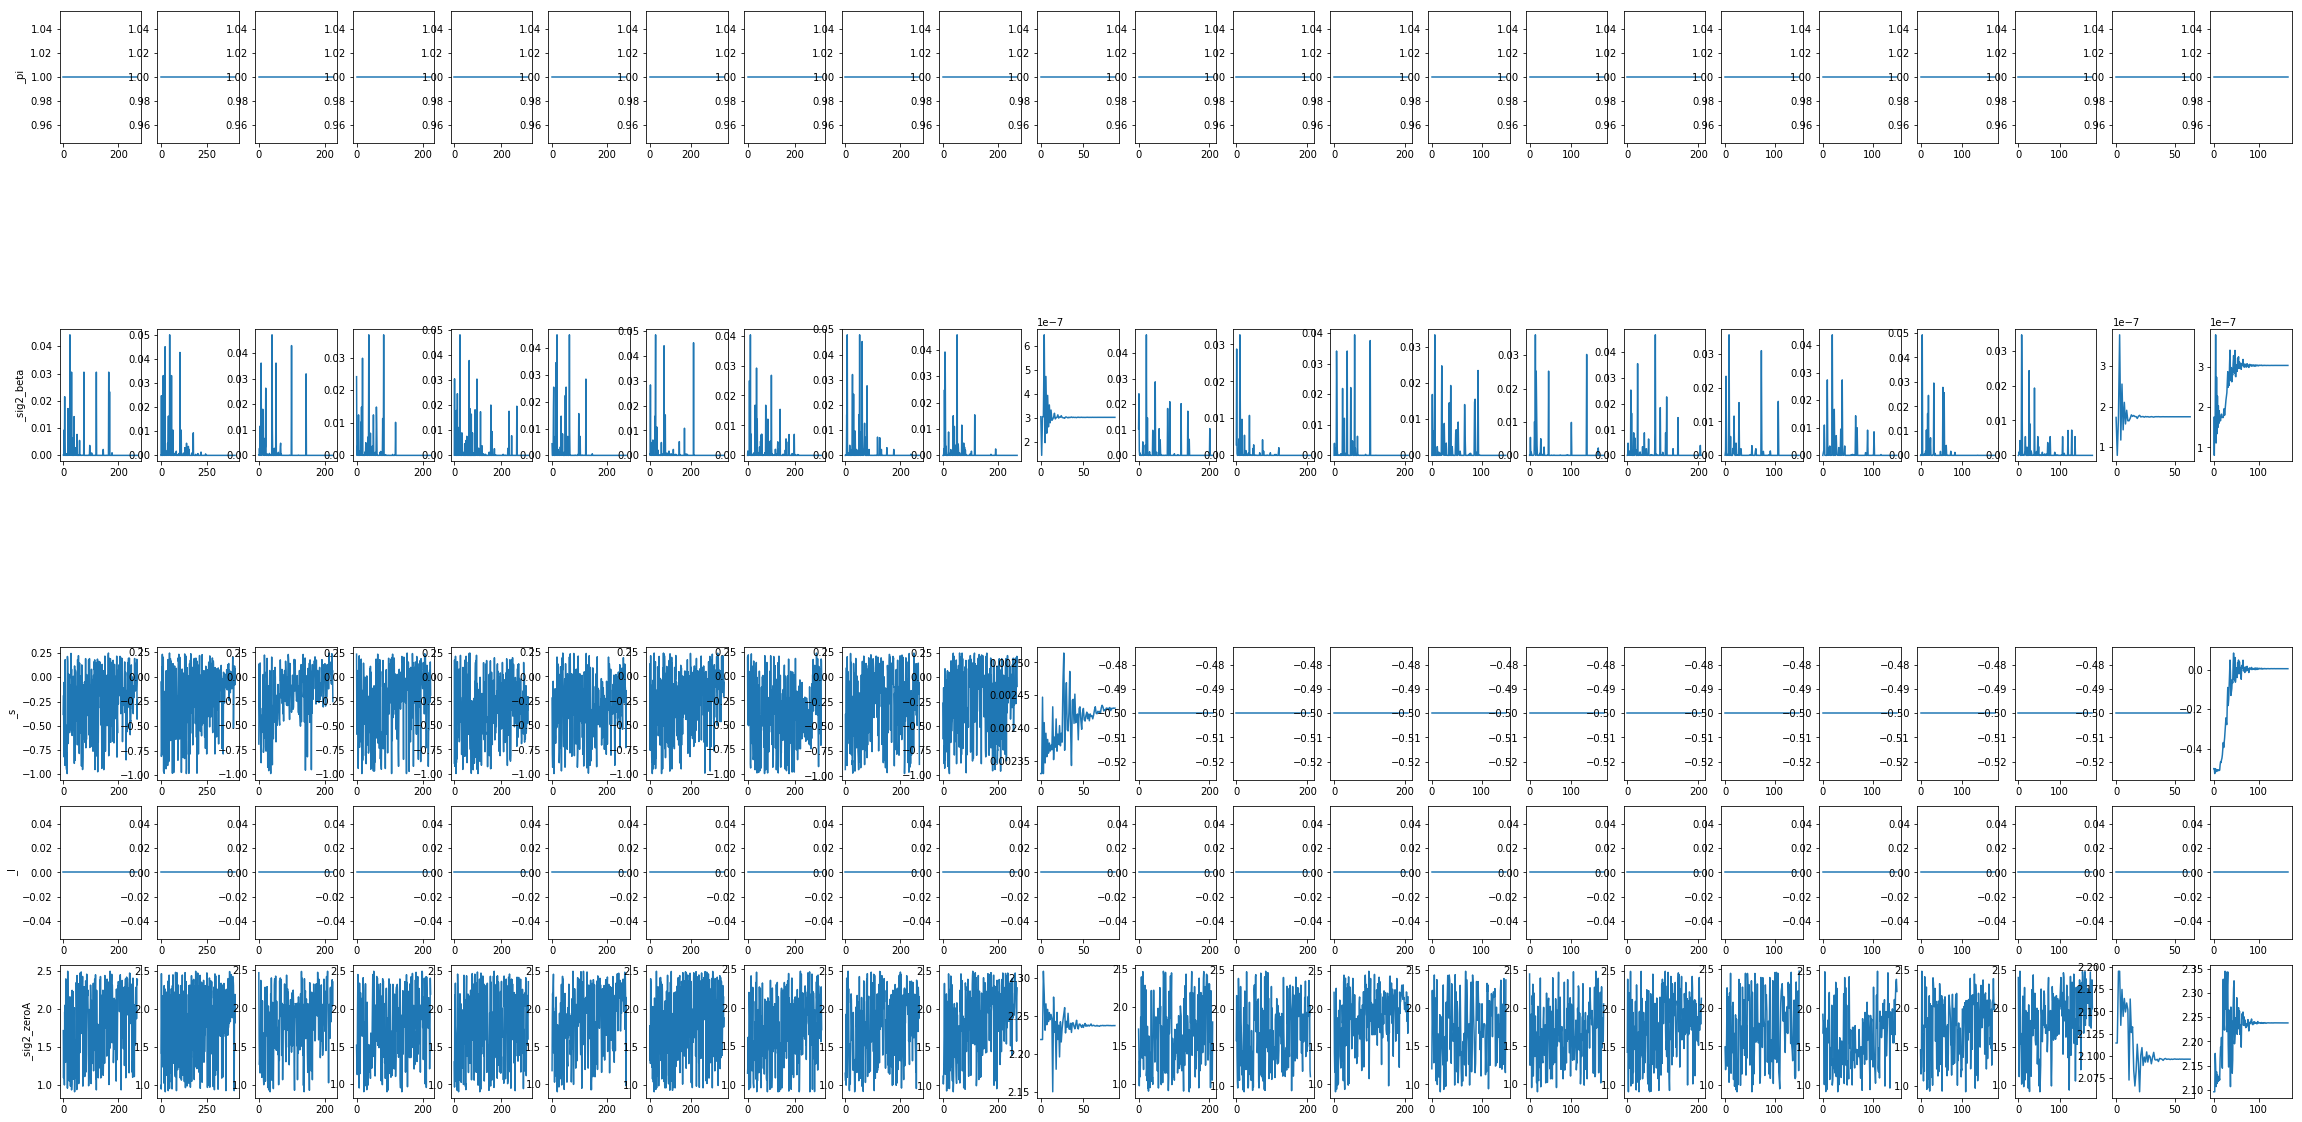

In [5]:
#fname = "/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/GIANT_HEIGHT_2018_UKB.models=3.outtag=run14.fit.log"
fname = "/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/GIANT_HEIGHT_2018_UKB.models=3.outtag=run15.fit.log"
#fname = "/home/oleksanf/vmshare/data/mixer_analysis/plsa_mixer/PGC_SCZ_2014_EUR.models=3.outtag=run13.fit.log"
lines = [x for x in open(fname).readlines() if ("=AnnotUnivariateParams" in x) or ("retrieve_weights" in x)]
groups = [g for g in groupby(lines, "retrieve_weights") if g]

#groups = [groups[1]]

plt.figure(figsize=(40, 20))
paramvec = '_pi _pi2 _sig2_beta _sig2_beta2 _s _l _sig2_zeroA'.split()
for pindex, param in enumerate(paramvec):
    for gindex, lines in enumerate(groups):
        if param not in parse(lines[0]): continue
        valvec = [parse(line)[param] for line in lines]
        if not valvec: continue
        plt.subplot(len(paramvec),len(groups), 1+gindex + pindex*len(groups))
        plt.plot(valvec)
        if gindex==0: plt.ylabel(param)


In [1]:
%load_ext autoreload
%autoreload 2
import precimed
import precimed.mixer
import logging
import numpy as np
#logging.getLogger().setLevel(logging.DEBUG)


In [58]:
np.power(np.array([1, 2,3]), 0.5)

array([1.        , 1.41421356, 1.73205081])

In [2]:
libbgmg = precimed.mixer.LibBgmg('/home/oleksanf/github/mixer/src/build/lib/libbgmg.so')


In [2]:
libbgmg = precimed.mixer.LibBgmg('/home/oleksanf/github/mixer/src/build/lib/libbgmg.so')
libbgmg.init_log("/home/oleksanf/github/mixer/testlog5.log")
libbgmg.log_message('Test log message succeeded?')
libbgmg.dispose()
libbgmg.defvec=[0, 1, 0, 1, 1, 0, 1, 1]
libbgmg.mafvec = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
libbgmg.chrnumvec = [1, 1, 1, 2, 2, 2, 2, 2]
libbgmg.zvec1 = [-1.5, 1.5, 2.5, -2.5, 0.123]
libbgmg.zvec2 = [1.5, -1.5, -2.5, 2.5, 0.123]
libbgmg.nvec1 = [100, 200, 100, 200, 300]
libbgmg.nvec2 = [1000, 2000, 1000, 2000, 3000]
libbgmg.weights = [0.2, 0.2, 0.2, 0.3, 0.3]
print('num_snp: {}'.format(libbgmg.num_snp))
print('num_tag: {}'.format(libbgmg.num_tag))
print('defvec: {}'.format(libbgmg.defvec))
print('mafvec: {}'.format(libbgmg.mafvec))
print('chrnumvec: {}'.format(libbgmg.chrnumvec))
print('zvec1: {}'.format(libbgmg.zvec1))
print('zvec2: {}'.format(libbgmg.zvec2))
print('nvec1: {}'.format(libbgmg.nvec1))
print('nvec2: {}'.format(libbgmg.nvec2))
print('weights: {}'.format(libbgmg.weights))
libbgmg

num_snp: 8
num_tag: 5
defvec: [1 3 4 6 7]
mafvec: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
chrnumvec: [1 1 1 2 2 2 2 2]
zvec1: [-1.5    1.5    2.5   -2.5    0.123]
zvec2: [ 1.5   -1.5   -2.5    2.5    0.123]
nvec1: [100. 200. 100. 200. 300.]
nvec2: [1000. 2000. 1000. 2000. 3000.]
weights: [0.2 0.2 0.2 0.3 0.3]


LibBgmg(_lib_name: /home/oleksanf/github/mixer/src/build/lib/libbgmg.so, _context_id: 0, num_snp: 8, num_tag: 5)

In [13]:
from importlib import reload
import precimed.mixer
reload(precimed.mixer)
libbgmg = precimed.mixer.LibBgmg('/home/oleksanf/github/mixer/src/build/lib/libbgmg.so')

libbgmg = precimed.mixer.LibBgmg('/home/oleksanf/github/mixer/src/build/lib/libbgmg.so')
libbgmg.init_log("/home/oleksanf/github/mixer/testlog5.log")
libbgmg.log_message('Test log message succeeded?')
libbgmg.dispose()

bim_file = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink/1000G.EUR.QC.@.bim'
frq_file = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink_freq/1000G.EUR.QC.@.frq'
plink_ld_bin = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink/1000G.EUR.QC.@.p05_SNPwind50k.ld.bin'
chr_labels = list(range(1, 23))
trait1_file = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/TMP/ldsr/PGC_SCZ_2014_EUR.sumstats.gz'
trait2_file = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/TMP/ldsr/PGC_BIP_2016.sumstats.gz'
exclude = ''; extract = ''
libbgmg.init(bim_file, frq_file, chr_labels, trait1_file, trait2_file, exclude, extract);
print(libbgmg)

options=[('r2min', 0.05), ('kmax', 100), ('max_causals', 0.03*libbgmg.num_snp), ('num_components', 3), 
         ('cache_tag_r2sum', False), ('threads', 6), ('seed', None), ('z1max', None)]
for opt, val in options: libbgmg.set_option(opt, val)

for chr_label in chr_labels: 
    libbgmg.set_ld_r2_coo_from_file(plink_ld_bin.replace('@', str(chr_label)))
    libbgmg.set_ld_r2_csr(chr_label);

randprune_n = 64
randprune_r2 = 0.1
libbgmg.set_weights_randprune(randprune_n, randprune_r2);

libbgmg.set_option('diag', 0)

AttributeError: module 'precimed.mixer' has no attribute 'LibBgmg'

In [42]:
randprune_n = 64
randprune_r2 = 0.1
libbgmg.set_weights_randprune(randprune_n, randprune_r2);


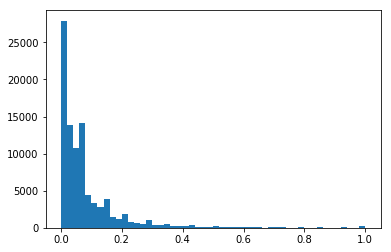

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(libbgmg.weights,bins=50);

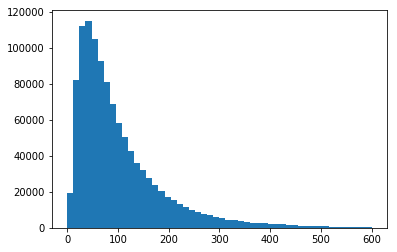

In [30]:
plt.hist(libbgmg.ld_tag_r2_sum, range=(0, 600), bins=50);

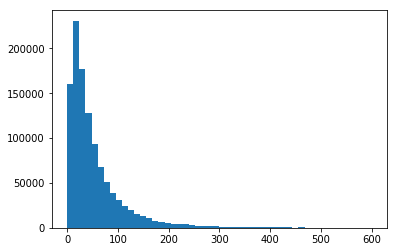

In [31]:
plt.hist(libbgmg.ld_tag_r4_sum, range=(0, 600), bins=50);

In [45]:
# it's possible to look at LD of a given SNP, and of the entire chromosome
for i in range(1,100):
    tag, r2 = libbgmg.get_ld_r2_snp(i)
    if len(tag>0):
        print(len(tag), list(zip(tag,r2)))
snp, tag, r2 = libbgmg.get_ld_r2_chr(21)

1 [(3450, 0.050812542)]
2 [(1627, 0.067566946), (1635, 0.065918975)]
4 [(2125, 0.05070573), (2128, 0.053543907), (4458, 0.05900664), (4465, 0.05159075)]
1 [(975, 0.06755169)]
1 [(975, 0.069092855)]
1 [(975, 0.069092855)]
12 [(1969, 0.05009537), (1971, 0.052048523), (3543, 0.051438164), (3579, 0.051819637), (3582, 0.051819637), (3585, 0.051544975), (3586, 0.0520943), (3589, 0.05168231), (3590, 0.05195697), (3591, 0.051422905), (3592, 0.052643627), (3594, 0.052109558)]


In [3]:
for i in range(1,100): libbgmg.calc_univariate_cost(1, 0.003, 1.2, 1e-4)

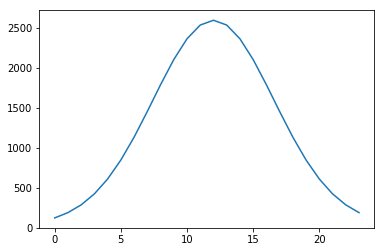

In [6]:
pdf=libbgmg.calc_univariate_pdf(1, 0.003, 1.2, 1e-4, np.arange(-3,3,0.25))
plt.plot(pdf);

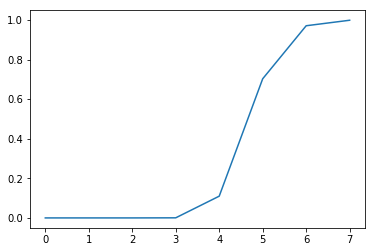

In [7]:
svec=libbgmg.calc_univariate_power(1, 0.003, 1.2, 1e-4, 5.45, [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
plt.plot(svec)

In [3]:
c0,c1,c2=libbgmg.calc_univariate_delta_posterior(1, 0.003, 1.2, 1e-4)


RuntimeError: Disable calc_univariate_delta_posterior - for some reason it crashes in native c++ plugin

In [ ]:
out_file = '/home/oleksanf/github/mixer/results'
lib_name = '/home/oleksanf/github/mixer/src/build/lib/libbgmg.so'
log_file = out_file + '.log'
bim_file = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink/1000G.EUR.QC.@.bim'
frq_file = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink_freq/1000G.EUR.QC.@.frq'
plink_ld_bin = '/home/oleksanf/vmshare/data/LDSR/1000G_EUR_Phase3_plink/1000G.EUR.QC.@.p05_SNPwind50k.ld.bin'
chr_labels = list(range(1, 23))
trait1_file = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/TMP/ldsr/PGC_SCZ_2014_EUR.sumstats.gz'
trait2_file = '/home/oleksanf/vmshare/data/MMIL/SUMSTAT/TMP/ldsr/PGC_BIP_2016.sumstats.gz'
exclude = ''; extract = ''
    options=[('r2min', 0.05), ('kmax', 100), ('max_causals', 0.03*libbgmg.num_snp), ('num_components', 3), 
             ('cache_tag_r2sum', False), ('threads', 6), ('seed', 123), ('z1max', None), ('z2max', None)]
randprune_n = 64
randprune_r2 = 0.1

def setub_libbgmg(lib_name, log_file, bim_file, frq_file, plink_ld_bin, chr_labels,
                  trait1_file, trait2_file, exclude, extract,
                  options, randprune_n, randprune_r2):

    libbgmg = precimed.mixer.LibBgmg(lib_name)
    libbgmg.init_log(log_file)
    libbgmg.dispose()

    libbgmg.init(bim_file, frq_file, chr_labels, trait1_file, trait2_file, exclude, extract);

    for opt, val in options:
        libbgmg.set_option(opt, val)

    for chr_label in chr_labels: 
        libbgmg.set_ld_r2_coo_from_file(plink_ld_bin.replace('@', str(chr_label)))
        libbgmg.set_ld_r2_csr(chr_label);

    libbgmg.set_weights_randprune(randprune_n, randprune_r2);

    libbgmg.set_option('diag', 0)
    return libbgmg

In [ ]:
def run_mixer(lib):


In [157]:
x=scipy.optimize.minimize_scalar(lambda x:(x-1)*(x-1),  method='brent', bracket=[-10, 10])
print(x)
print(type(x))

     fun: 4.930380657631324e-32
    nfev: 9
     nit: 5
 success: True
       x: 1.0000000000000002
<class 'scipy.optimize.optimize.OptimizeResult'>


In [236]:
from importlib import reload
import precimed.mixer
reload(precimed.mixer)
from precimed.mixer.utils import *
from precimed.mixer.utils import UnivariateParams
from precimed.mixer.utils import BivariateParams
from precimed.mixer.utils import _log_exp_converter
from precimed.mixer.utils import _logit_logistic_converter
from precimed.mixer.utils import _arctanh_tanh_converter
from precimed.mixer.utils import UnivariateParametrization_constPI
from precimed.mixer.utils import UnivariateParametrization_constH2_constSIG2ZERO
from precimed.mixer.utils import UnivariateParametrization_constPI_constSIG2BETA
from precimed.mixer.utils import UnivariateParametrization
from precimed.mixer.utils import BivariateParametrization_constUNIVARIATE_constRG_constRHOZERO
from precimed.mixer.utils import BivariateParametrization_constUNIVARIATE_constRG_constRHOZERO_boundedPI
from precimed.mixer.utils import BivariateParametrization_constSIG2BETA_constSIG2ZERO_infPI_maxRG
from precimed.mixer.utils import BivariateParametrization_constUNIVARIATE
from precimed.mixer.utils import BivariateParametrization_constUNIVARIATE_natural_axis
from precimed.mixer.utils import BivariateParametrization_constUNIVARIATE_constRHOBETA_constPI
from precimed.mixer.utils import _hessian_robust
from precimed.mixer.utils import _max_rg
from precimed.mixer.utils import _calculate_univariate_uncertainty
from precimed.mixer.utils import _calculate_bivariate_uncertainty

print(UnivariateParams(0.001, 1e-4, 1.23).cost(libbgmg, 1))
print(UnivariateParams(0.001, 1e-4, 1.23).cost(libbgmg, 2))
print(BivariateParams([0.001, 0.002, 0.004], [1e-4, 3e-4], 0.8, [1.23, 1.06], 0.4).cost(libbgmg))

#scalar_optimizer = scipy.optimize.fminbound
params12_fitted, _ = BivariateParametrization_constUNIVARIATE_constRG_constRHOZERO_boundedPI(
    const_params1=params[0],
    const_params2=params[1],
    const_rg=params12._rg(),
    const_rho_zero=params12._rho_zero,
    lib=libbgmg).fit(scalar_optimizer)
print(params12_fitted)

143039.9667054704
136117.94951642904
279813.56074795313
BivariateParams(_pi: [0.0012466754854858091, 0.0003354573743336747, 0.0028265604933306715], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 0.8945159908412117, _sig2_zero: [1.1755915719572747, 1.084084668490775], _rho_zero: 0.26921714348165393, rg: 0.7045218190412361)


In [85]:
import scipy.optimize

libbgmg.set_option('fast_cost', 1);
    
optimizer = lambda func, x0: scipy.optimize.minimize(func, x0, method='Nelder-Mead')

params = []

for trait in [1, 2]:
    params0, details = UnivariateParametrization_constPI(1.0, 1.5, 1e-4, libbgmg, trait=trait).fit(optimizer)
    #print(params0)

    params1, details = UnivariateParametrization_constH2_constSIG2ZERO(0.01, params0, libbgmg, trait=trait).fit(optimizer)
    #print(params1)

    params2, details = UnivariateParametrization_constPI_constSIG2BETA(1.0, params1, libbgmg, trait=trait).fit(optimizer)
    #print(params2)

    params3, details = UnivariateParametrization(params2, libbgmg, trait=trait).fit(optimizer)
    print(params3)
    
    params.append(params3)

alpha = 0.05
totalhet = 2.0 * np.dot(libbgmg.mafvec, 1.0 - libbgmg.mafvec) 
num_samples = 10000

# That's the most appropriate initialization for the bivariate model
# BivariateParametrization_constSIG2BETA_constSIG2ZERO_infPI_maxRG - not used
# BivariateParametrization_constUNIVARIATE_constRG_constRHOZERO    - used to fit the full model
zcorr = np.corrcoef(libbgmg.zvec1, libbgmg.zvec2)[0, 1]
params12, details = BivariateParametrization_constUNIVARIATE(
    const_params1=params[0],
    const_params2=params[1],
    init_pi12=min(params[0]._pi, params[1]._pi)*0.1,
    init_rho_beta=zcorr,
    init_rho_zero=zcorr,
    lib=libbgmg).fit(optimizer)
print(params12)

ci1, ci_sample1 = _calculate_univariate_uncertainty(UnivariateParametrization(params[0], libbgmg, trait=1), alpha, totalhet, libbgmg.num_snp, num_samples)
ci2, ci_sample2 = _calculate_univariate_uncertainty(UnivariateParametrization(params[1], libbgmg, trait=2), alpha, totalhet, libbgmg.num_snp, num_samples)
ci12, ci_sample12 = _calculate_bivariate_uncertainty(BivariateParametrization_constUNIVARIATE(
    const_params1=params[0],
    const_params2=params[1],
    init_pi12=params12._pi[2],
    init_rho_beta=params12._rho_beta,
    init_rho_zero=params12._rho_zero,
    lib=libbgmg), [ci_sample1, ci_sample2], alpha, totalhet, libbgmg.num_snp, num_samples)

print('\nUnivariate (trait1):')
for k, v in ci1.items():
        print('{}: pe={:.3g}, mean={:.3g}, median={:.3g}, std={:.3g}, ci=[{:.3g}, {:.3g}]'.format(k, v['point_estimate'], v['mean'], v['median'], v['std'], v['lower'], v['upper']))
print('\nUnivariate (trait2):')
for k, v in ci2.items():
        print('{}: pe={:.3g}, mean={:.3g}, median={:.3g}, std={:.3g}, ci=[{:.3g}, {:.3g}]'.format(k, v['point_estimate'], v['mean'], v['median'], v['std'], v['lower'], v['upper']))
print('\nBivariate:')
for k, v in ci12.items():
        print('{}: pe={:.3g}, mean={:.3g}, median={:.3g}, std={:.3g}, ci=[{:.3g}, {:.3g}]'.format(k, v['point_estimate'], v['mean'], v['median'], v['std'], v['lower'], v['upper']))

UnivariateParams(_pi: 0.004073235978816481, _sig2_beta: 5.288619957821589e-05, _sig2_zero: 1.1755915719572747)
UnivariateParams(_pi: 0.0031620178676643462, _sig2_beta: 5.231128193651721e-05, _sig2_zero: 1.084084668490775)
BivariateParams(_pi: [0.0012449932750385182, 0.00033377516388638376, 0.0028282427037779625], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 0.8939839416846624, _sig2_zero: [1.1755915719572747, 1.084084668490775], _rho_zero: 0.26921714348165393, rg: 0.7045218190412361)

Univariate (trait1):
pi: pe=0.00407, mean=0.0041, median=0.0041, std=0.000453, ci=[0.00329, 0.00506]
nc: pe=4.07e+04, mean=4.1e+04, median=4.1e+04, std=4.53e+03, ci=[3.29e+04, 5.06e+04]
nc@p9: pe=9.2e+03, mean=9.26e+03, median=9.26e+03, std=1.02e+03, ci=[7.43e+03, 1.14e+04]
sig2_beta: pe=5.29e-05, mean=5.32e-05, median=5.32e-05, std=5.34e-06, ci=[4.34e-05, 6.44e-05]
sig2_zero: pe=1.18, mean=1.18, median=1.18, std=0.00889, ci=[1.16, 1.19]
h2: pe=0.447, mean=0.447, median=0.447, st

In [144]:
# That's the most appropriate initialization for the bivariate model
# BivariateParametrization_constSIG2BETA_constSIG2ZERO_infPI_maxRG - not used
# BivariateParametrization_constUNIVARIATE_constRG_constRHOZERO    - used to fit the full model
zcorr = np.corrcoef(libbgmg.zvec1, libbgmg.zvec2)[0, 1]
params12, details = BivariateParametrization_constUNIVARIATE(
    const_params1=params[0],
    const_params2=params[1],
    init_pi12=min(params[0]._pi, params[1]._pi)*0.1,
    init_rho_beta=zcorr,
    init_rho_zero=zcorr,
    lib=libbgmg).fit(optimizer)
print(params12)

BivariateParams(_pi: [0.0012449932750385182, 0.00033377516388638376, 0.0028282427037779625], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 0.8939839416846624, _sig2_zero: [1.1755915719572747, 1.084084668490775], _rho_zero: 0.26921714348165393, rg: 0.7045218190412361)


In [18]:
params12, details = BivariateParametrization_constSIG2BETA_constSIG2ZERO_infPI_maxRG(
    const_sig2_beta=[p._sig2_beta for p in params],
    const_sig2_zero=[p._sig2_zero for p in params],
    max_rg=_max_rg(params[0]._pi, params[1]._pi),
    init_rho_beta=0.5, init_rho_zero=0.1, lib=libbgmg).fit(optimizer)
print(params12)

params12, details = BivariateParametrization_constUNIVARIATE_constRG_constRHOZERO(
    const_params1=params[0],
    const_params2=params[1],
    const_rg=params12._rho_beta,
    const_rho_zero=params12._rho_zero,
    init_pi12=min(params[0]._pi, params[1]._pi)*0.95,
    lib=libbgmg).fit(optimizer)
print(params12)

params12, details = BivariateParametrization_constUNIVARIATE(
    const_params1=params[0],
    const_params2=params[1],
    init_pi12=min(params[0]._pi, params[1]._pi)*0.5,
    init_rho_beta=0,
    init_rho_zero=0,
    lib=libbgmg).fit(optimizer)
print(params12)

params12, details = BivariateParametrization_constUNIVARIATE_constRHOBETA_constPI(
    const_params1=params[0],
    const_params2=params[1],
    const_pi12=params12._pi[2],
    const_rho_beta=params12._rho_beta,
    init_rho_zero=0,
    lib=libbgmg).fit(optimizer)
print(params12)

BivariateParams(_pi: [0, 0, 1], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 0.8810739768325555, _sig2_zero: [1.1755915719572747, 1.084084668490775], _rho_zero: 0.8528486201057031, rg: 0.8810739768325555)
BivariateParams(_pi: [0.0015524944994159688, 0.0006412763882638344, 0.002520741479400512], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 1.0, _sig2_zero: [1.1755915719572747, 1.084084668490775], _rho_zero: 0.27, rg: 0.7023868342220096)
BivariateParams(_pi: [0.0015403841166866214, 0.0006291660055344869, 0.0025328518621298593], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 0.9999999995949107, _sig2_zero: [1.1755915719572747, 1.084084668490775], _rho_zero: 0.2690626563807834, rg: 0.7057613066680437)
BivariateParams(_pi: [0.0015403841166866214, 0.0006291660055344869, 0.0025328518621298593], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 0.9999999995949107, _sig2_zero: [1.1755915719572747, 1

In [239]:
params12, details = BivariateParametrization_constUNIVARIATE_natural_axis(
    const_params1=params[0],
    const_params2=params[1],
    init_pi12=min(params[0]._pi, params[1]._pi)*0.5,
    init_rho_beta=0,
    init_rho_zero=0,
    lib=libbgmg).fit(optimizer)
print(params12)

BivariateParams(_pi: [0.0012389994058291652, 0.0003277812946770307, 0.0028342365729873155], _sig2_beta: [5.288619957821589e-05, 5.231128193651721e-05], _rho_beta: 0.8928580429674069, _sig2_zero: [1.1755915719572747, 1.084084668490775], _rho_zero: 0.26906143314603836, rg: 0.7051257384792755)
